# CS 3654 Team Project

### Team Info:  
Project Title:  Correlations on Climate Change  
Team name:  Greenhouse Guys  
Team member names and PIDs: Atharva Haldankar (ahaldankar), Fairuz Ahmed (ahfairuz), Andrew Ahn (aandrew17), Jonathan Jwa (jonathanyjwa23), Justin Perez (justinmp)

### Project Introduction:

**Initial Description:** We plan to analyze climate data based on country to understand which countries are responsible for the majority of greenhouse gas emissions, what the characteristics of those countries are, and what negative effects greenhouse emissions have on people and the environment.

**Potential research questions:**  
    1. Which countries produce the most greenhouse gases? Which countries produce the least?  
    2. Is there a correlation between GDP and greenhouse gas emissions?  
    3. Does a country's use of renewable energy decrease their emissions?  
    4. Does a country's population or land area have anything to do with greenhouse emissions?  
    5. What forms of government do the countries that produce the most greenhouse gases have?  
    6. Do greenhouse emissions come primarily from urban or rural settings?  
    7. Which countries are affected most by greenhouse emissions?  
    8. Do emissions impact human life expectancy?  
    
**Potential source data:**
1. https://www.kaggle.com/datasets/sudalairajkumar/undata-country-profiles
2. https://worldpopulationreview.com/country-rankings/greenhouse-gas-emissions-by-country
3. https://www.kaggle.com/saurabhshahane/green-house-gas-historical-emission-data  
4. https://www.kaggle.com/brendan45774/countries-life-expectancy
5. https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

### Individual Contributions: 
Atharva:  
- Completed QACs for questions 4 and 5 in potential research questions section (Population/Land Area vs. Greenhouse Emissions and Government Forms vs. CO2 Emissions).  
- Edited final report and added more information to Q and C sections of other team member's reports.  

Justin  
- QAC on GDP vs. Greenhouse Emissions  

Andrew  
- QAC on Life Expectancy vs. Greenhouse Emissions

Fairuz
- QAC on Renewable Energy and CO2 emissions

Jonathan
- QAC on Countries that Produce the Most and Least CO2 Emissions

### Procedural Notes
- When analyzing population vs. CO2 emissions, we tried fitting a logarithmic model to the data, due to how the data was structured. However, since this model had a lower R-value than the linear model, we decided not to include those results. 
- For population vs. CO2 emissions, we also tried fitting a polynomial model. However, despite specifying the model as a polynomial of degree 2, we still got a linear fit, since the model computed an x^2 coefficient of 0. 
- For our initial questions, we used the CO2 emission estimates column from the country profiles kaggle dataset (link 1). However, since emissions data from the world population review site (link 2) is slightly more up to date, we used this source for some of the later questions. 

**DimRed and Analysis:** 

In [1]:
import pandas
import numpy
import sklearn.metrics.pairwise
import sklearn.manifold
import sklearn.cluster
import matplotlib
import matplotlib.pyplot as plt
# pandas.options.mode.chained_assignment = None  # default='warn'

In [2]:
dirtyCountries = pandas.read_csv("country_profile_variables.csv")
dirtyCountries

cont_preJoin = dirtyCountries.copy()

# Relevant Columns: 
# Country, Surface Area, Population (from other data set), 
# GDP, GDP growth rate, Economy: Agriculture, 
# Threatened Species, CO2 emission estimates (other dataset), Energy production (Petajoules)
cont_preJoin = cont_preJoin[['country', 'Surface area (km2)', 'GDP: Gross domestic product (million current US$)', 
                               'GDP growth rate (annual %, const. 2005 prices)', 'Economy: Agriculture (% of GVA)', 
                             'Economy: Industry (% of GVA)', 'Economy: Services and other activity (% of GVA)',
                               'Threatened species (number)', 'Energy production, primary (Petajoules)',
                                'Population in thousands (2017)', 'Population density (per km2, 2017)']]
cont_preJoin.shape
cont_preJoin.dtypes
# cont_preJoin.head()

country                                               object
Surface area (km2)                                    object
GDP: Gross domestic product (million current US$)      int64
GDP growth rate (annual %, const. 2005 prices)        object
Economy: Agriculture (% of GVA)                       object
Economy: Industry (% of GVA)                         float64
Economy: Services and other activity (% of GVA)      float64
Threatened species (number)                           object
Energy production, primary (Petajoules)                int64
Population in thousands (2017)                         int64
Population density (per km2, 2017)                   float64
dtype: object

In [3]:
# Cleaning: Make sure columns have appropriate data types. 
cont_preJoin['Surface area (km2)'] = dirtyCountries['Surface area (km2)'].map(lambda val: int(val.replace('~', '')))
cont_preJoin['GDP growth rate (annual %, const. 2005 prices)'] = dirtyCountries['GDP growth rate (annual %, const. 2005 prices)'].map(lambda val : float(val.replace('~', '')))
cont_preJoin['Economy: Agriculture (% of GVA)'] = dirtyCountries['Economy: Agriculture (% of GVA)'].map(lambda val : float(val.replace('~', '')))
cont_preJoin['Threatened species (number)'] = dirtyCountries['Threatened species (number)'].map(lambda val : float(val.replace('~', '')))

In [4]:
cont_preJoin.shape
cont_preJoin.head(5)
# cont_preJoin[:-10]
cont_preJoin.dtypes

country                                               object
Surface area (km2)                                     int64
GDP: Gross domestic product (million current US$)      int64
GDP growth rate (annual %, const. 2005 prices)       float64
Economy: Agriculture (% of GVA)                      float64
Economy: Industry (% of GVA)                         float64
Economy: Services and other activity (% of GVA)      float64
Threatened species (number)                          float64
Energy production, primary (Petajoules)                int64
Population in thousands (2017)                         int64
Population density (per km2, 2017)                   float64
dtype: object

In [5]:
# Now, make sure values are in proper range
filteredOutRows = cont_preJoin.loc[cont_preJoin.eq(-99).any(1), :]
len(filteredOutRows)

# Map all -99s to NAs. 
cont_preJoin = cont_preJoin.replace(-99, numpy.NaN)
cont_preJoin = cont_preJoin.dropna()
cont_preJoin.shape
cont_preJoin.head()

,country,Surface area (km2),GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),Economy: Services and other activity (% of GVA),Threatened species (number),"Energy production, primary (Petajoules)",Population in thousands (2017),"Population density (per km2, 2017)"
0,Afghanistan,652864.0,20270.0,-2.4,23.3,23.3,53.3,2.1,5.0,35530,54.4
1,Albania,28748.0,11541.0,2.6,22.4,26.0,51.7,28.2,36.0,2930,106.9
2,Algeria,2381741.0,164779.0,3.8,12.2,37.3,50.5,0.8,55.0,41318,17.3
4,Andorra,468.0,2812.0,0.8,0.5,10.8,88.6,34.0,119.0,77,163.8
5,Angola,1246700.0,117955.0,3.0,6.8,51.2,42.0,46.5,25.0,29784,23.9


In [6]:
# Now, process the other dataset. 
dirtyEmissions = pandas.read_csv("CO2Emissions.csv")

# Create a copy of this dataset to preserve the original. Only keep the relevant columns. 
emissions_preJoin = dirtyEmissions.copy()
emissions_preJoin = emissions_preJoin[['Country Name', '2017']]

# Overview information about the dataset. 
emissions_preJoin.shape
emissions_preJoin.dtypes
emissions_preJoin.head()

,Country Name,2017
0,Aruba,NaN
1,Africa Eastern and Southern,0.959978
2,Afghanistan,0.203328
3,Africa Western and Central,0.476438
4,Angola,1.034317


In [7]:
# Clean emissions_preJoin by dropping NaN values. Let's rename the '2017' column to 'Emissions 2017'
emissions_preJoin = emissions_preJoin.dropna()
emissions_preJoin.rename(columns={'2017':'Emissions 2017 (Metric Tons Per Capita)'}, inplace=True)
# emissions_preJoin = emissions_preJoin.reset_index(drop=True)
emissions_preJoin.head()
# emissions_preJoin[emissions_preJoin['Country Name'] == 'Russia']

,Country Name,Emissions 2017 (Metric Tons Per Capita)
1,Africa Eastern and Southern,0.959978
2,Afghanistan,0.203328
3,Africa Western and Central,0.476438
4,Angola,1.034317
5,Albania,1.948872


In [8]:
# Check for any missing or invalid values in the emissions dataset
len(emissions_preJoin[emissions_preJoin['Emissions 2017 (Metric Tons Per Capita)'] < 0])

0

In [9]:
# Before we join: Let's make sure that the major emitters of CO2 emissions are all represented. 
# Create a dictionary which maps country names in cont_preJoin to the corresponding names in emissions_preJoin
countryMappings = {
    'United States of America': 'United States',
    # 'Russian Federation' : 'Russia',
    'Republic of Korea' : 'Korea, Rep.',
    'Viet Nam' : 'Vietnam',
    'Czechia' : 'Czech Republic'
}

In [10]:
# It looks like we are all good with cleaning. Now, let's join cont_preJoin with emissions_preJoin. 
# Do an inner join so we don't get any missing or NaN values. 
cont_preJoin.country = cont_preJoin.country.map(lambda c : countryMappings[c] if c in countryMappings.keys() else c)
cont_preJoin.country = cont_preJoin.country.map(lambda c : c[:(c.find("(") - 1)] if c.find("(") != -1 else c)
# cont_preJoin.country = cont_preJoin.country.map(lambda c : c.upper())
countryStats = pandas.merge(cont_preJoin, emissions_preJoin, how='inner', left_on='country', right_on='Country Name')
countryStats.shape
# emissions_preJoin[emissions_preJoin['Country Name'] == 'Russian Federation']
# cont_preJoin.head()
# cont_preJoin.shape

(168, 13)

In [11]:
# We got the majority of countries from both datasets. Here's a sample of the joined data. 
countryStats.shape
countryStats.head()

,country,Surface area (km2),GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),Economy: Services and other activity (% of GVA),Threatened species (number),"Energy production, primary (Petajoules)",Population in thousands (2017),"Population density (per km2, 2017)",Country Name,Emissions 2017 (Metric Tons Per Capita)
0,Afghanistan,652864.0,20270.0,-2.4,23.3,23.3,53.3,2.1,5.0,35530,54.4,Afghanistan,0.203328
1,Albania,28748.0,11541.0,2.6,22.4,26.0,51.7,28.2,36.0,2930,106.9,Albania,1.948872
2,Algeria,2381741.0,164779.0,3.8,12.2,37.3,50.5,0.8,55.0,41318,17.3,Algeria,3.505748
3,Andorra,468.0,2812.0,0.8,0.5,10.8,88.6,34.0,119.0,77,163.8,Andorra,6.104134
4,Angola,1246700.0,117955.0,3.0,6.8,51.2,42.0,46.5,25.0,29784,23.9,Angola,1.034317


In [12]:
# Now, we are ready to analyze the data. 
# Let's begin by normalizing the data, so that the columns are weighted equally, 
countryStats.head()
preNorm = countryStats.drop(['country', 'Country Name'], axis=1)
preNorm.head()
norm = (preNorm-preNorm.mean())/(preNorm.std())
norm.head()

,Surface area (km2),GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),Economy: Services and other activity (% of GVA),Threatened species (number),"Energy production, primary (Petajoules)",Population in thousands (2017),"Population density (per km2, 2017)",Emissions 2017 (Metric Tons Per Capita)
0,-0.037036,-0.236951,-1.285537,0.887978,-0.401350,-0.447782,-1.249093,-0.674456,-0.039423,-0.233394,-0.836957
1,-0.341984,-0.242041,-0.066331,0.816368,-0.183036,-0.561537,-0.124909,-0.433539,-0.250751,-0.154724,-0.492991
2,0.807708,-0.152682,0.226279,0.004783,0.730651,-0.646853,-1.305087,-0.285880,-0.001903,-0.288987,-0.186203
3,-0.355802,-0.247131,-0.505245,-0.926151,-1.412065,2.061930,0.124909,0.211496,-0.269246,-0.069462,0.325818
4,0.253118,-0.179987,0.031206,-0.424879,1.854566,-1.251174,0.663311,-0.519026,-0.076671,-0.279097,-0.673207


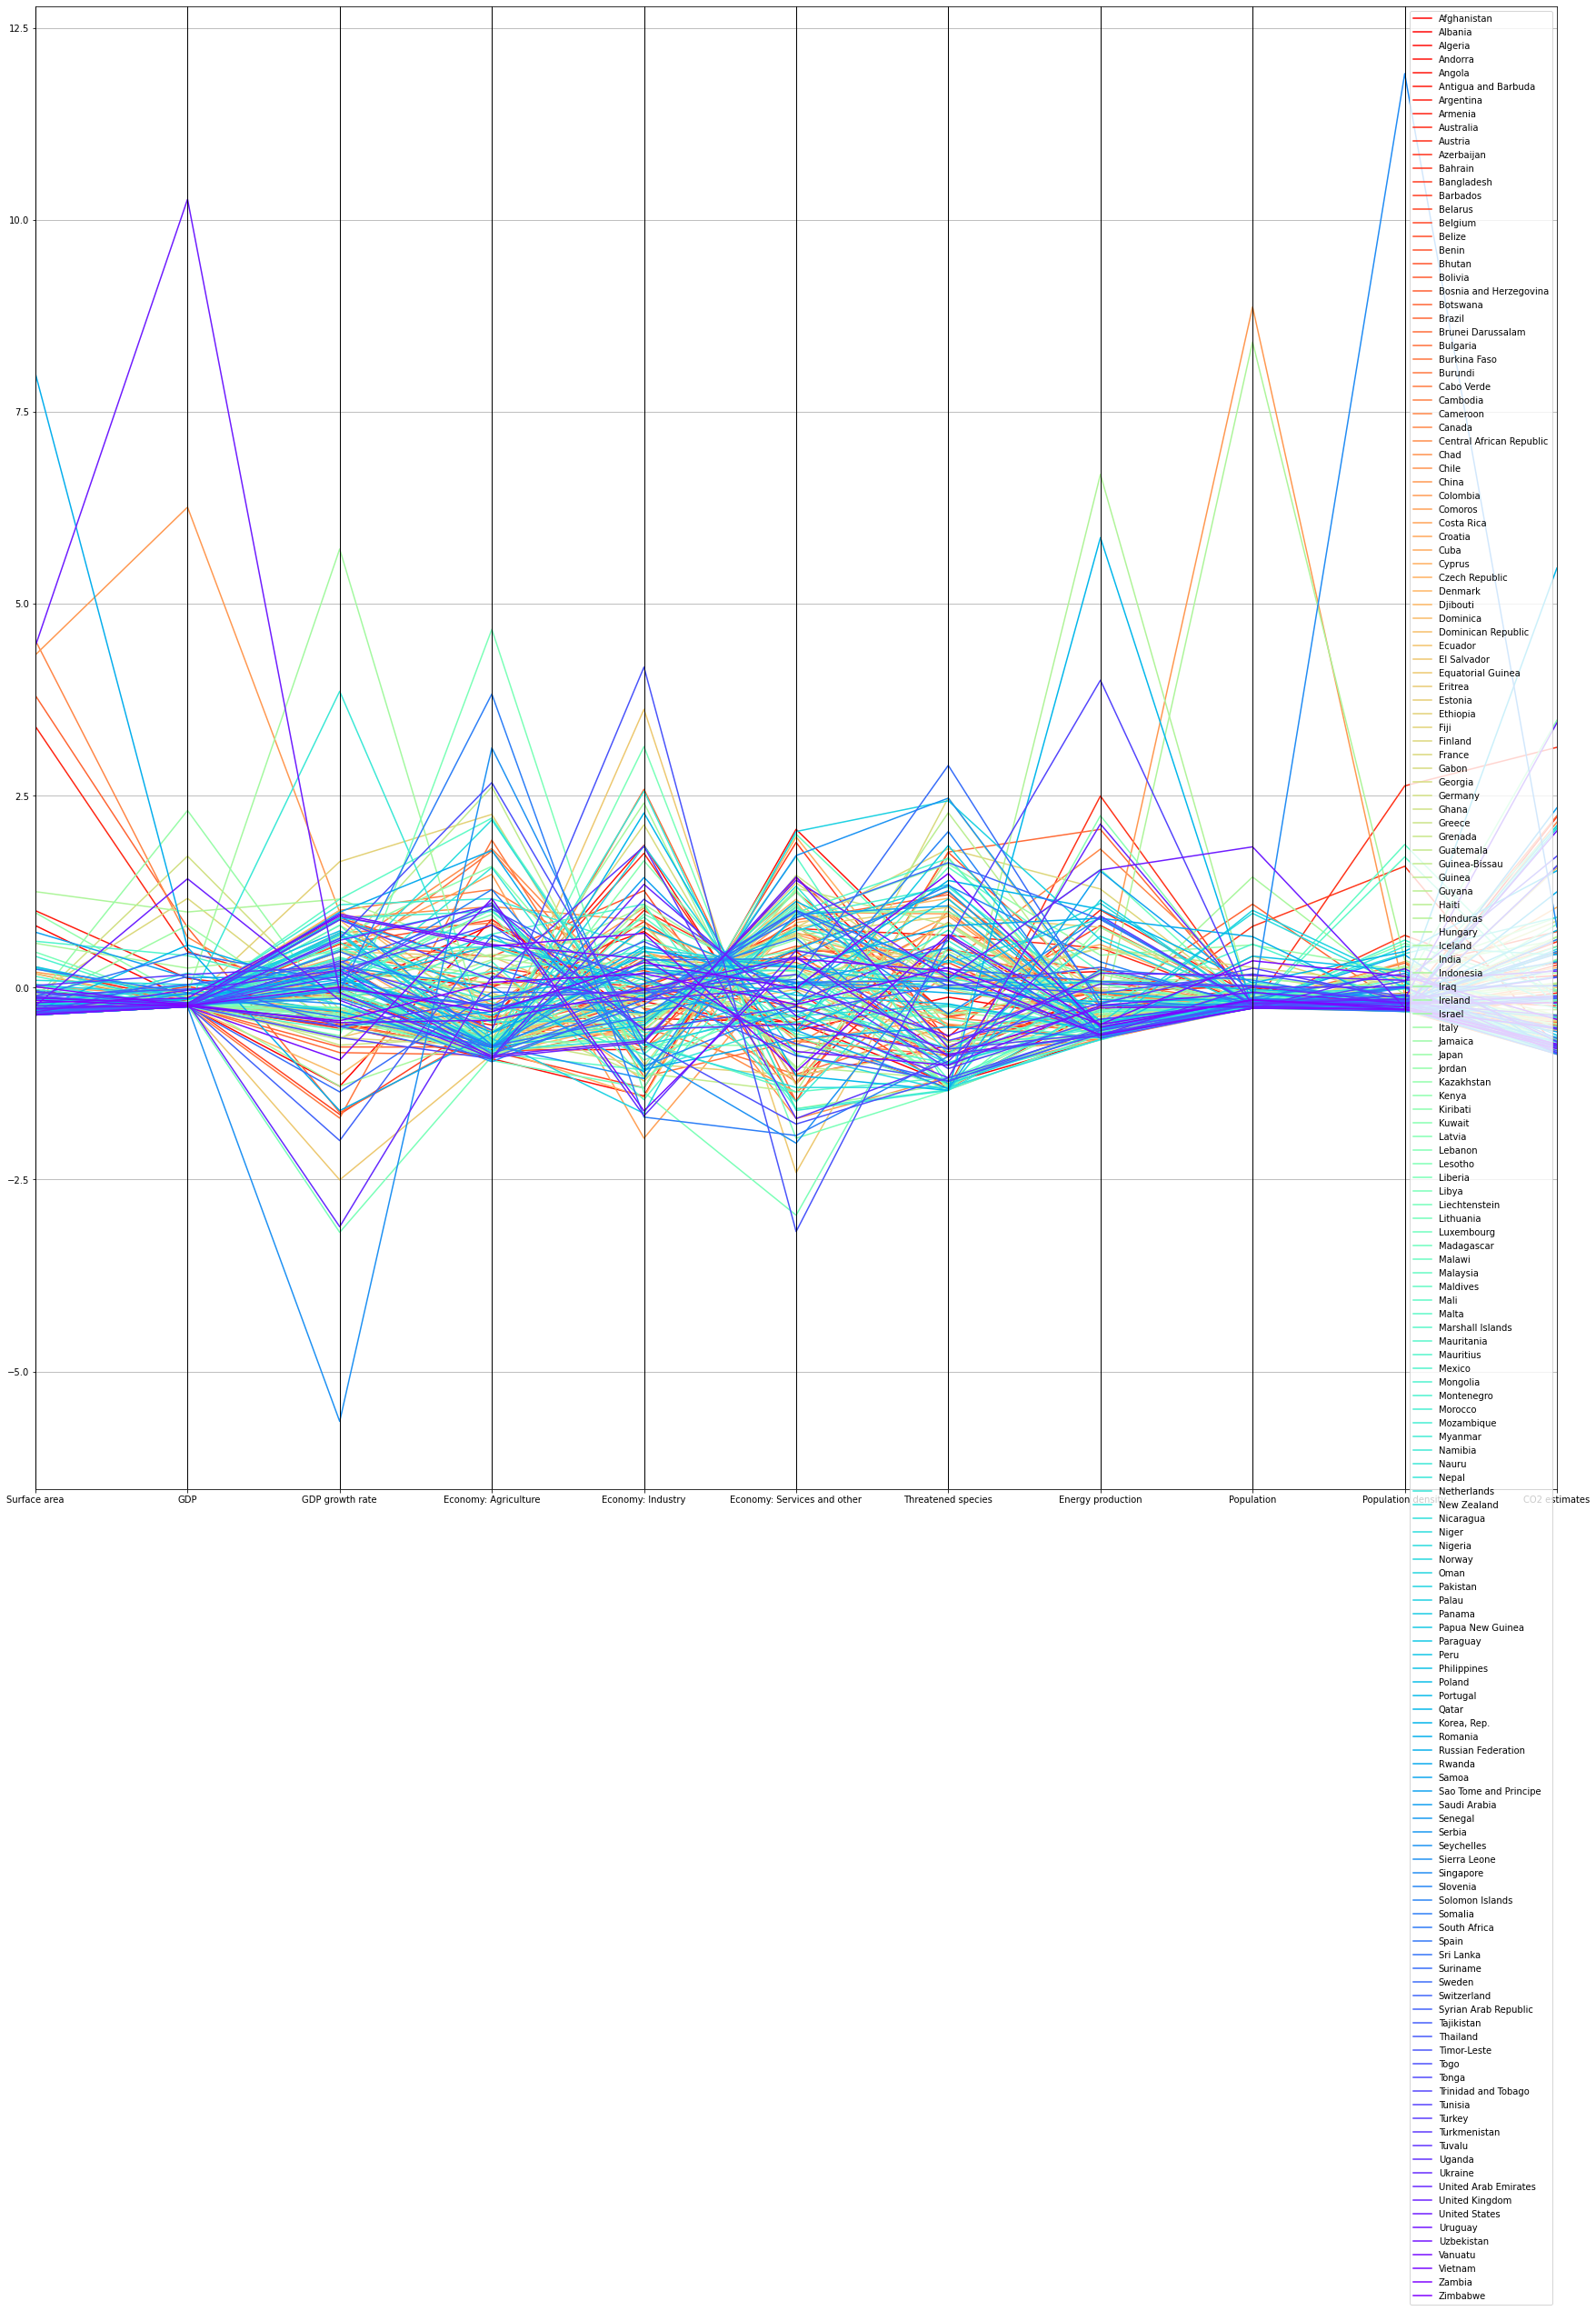

In [13]:
# Let's visualize the data using a parallel coordinates plot. 
normWithCountries = norm.join(countryStats.country)
# Rename the columns for readability
normWithCountries.columns = ['Surface area', 'GDP', 'GDP growth rate', 'Economy: Agriculture', 
                                'Economy: Industry', 'Economy: Services and other', 
                                'Threatened species', 'Energy production', 'Population', 
                                'Population density', 'CO2 estimates', 'country']
parallelPlot = pandas.plotting.parallel_coordinates(normWithCountries, class_column='country', colormap='rainbow_r')
parallelPlot.figure.set_size_inches(30,30, forward=True)

In [14]:
norm.index = normWithCountries.country
norm.head()

,Surface area (km2),GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),Economy: Services and other activity (% of GVA),Threatened species (number),"Energy production, primary (Petajoules)",Population in thousands (2017),"Population density (per km2, 2017)",Emissions 2017 (Metric Tons Per Capita)
country,,,,,,,,,,,
Afghanistan,-0.037036,-0.236951,-1.285537,0.887978,-0.401350,-0.447782,-1.249093,-0.674456,-0.039423,-0.233394,-0.836957
Albania,-0.341984,-0.242041,-0.066331,0.816368,-0.183036,-0.561537,-0.124909,-0.433539,-0.250751,-0.154724,-0.492991
Algeria,0.807708,-0.152682,0.226279,0.004783,0.730651,-0.646853,-1.305087,-0.285880,-0.001903,-0.288987,-0.186203
Andorra,-0.355802,-0.247131,-0.505245,-0.926151,-1.412065,2.061930,0.124909,0.211496,-0.269246,-0.069462,0.325818
Angola,0.253118,-0.179987,0.031206,-0.424879,1.854566,-1.251174,0.663311,-0.519026,-0.076671,-0.279097,-0.673207


In [15]:
# Now let's perform dimension reduction. 
# First, compute the distance matrix. 
distHD = sklearn.metrics.pairwise.euclidean_distances(norm)
distHD = pandas.DataFrame(distHD, columns=norm.index, index=norm.index)
distHD

country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Vietnam,Zambia,Zimbabwe
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,1.770933,2.385262,3.927641,3.604327,3.386530,2.557636,1.590775,5.540821,3.569961,...,2.368027,5.913680,3.628030,12.536773,1.940346,2.561251,2.151169,3.318533,3.371276,2.038698
Albania,1.770933,0.000000,2.122466,3.574754,2.691184,2.798766,2.399065,0.797085,5.359421,2.749063,...,3.293261,5.357402,3.408100,12.455674,1.811416,1.578958,2.007878,1.820688,2.165808,1.096163
Algeria,2.385262,2.122466,0.000000,4.167407,2.516183,3.152664,1.591587,1.622241,4.322737,3.207089,...,3.707427,4.658211,3.441509,11.942974,1.955920,1.414620,3.658202,2.527291,3.098322,2.168095
Andorra,3.927641,3.574754,4.167407,0.000000,4.946160,1.336582,2.859405,3.592435,4.784306,2.053605,...,3.836562,5.406892,2.195065,11.998632,2.645443,4.218475,3.055817,4.525849,3.429835,3.231817
Angola,3.604327,2.691184,2.516183,4.946160,0.000000,4.125043,3.205864,2.767445,5.584946,3.316247,...,4.274704,5.392899,4.529925,12.491808,3.047524,2.733270,4.325391,1.928287,2.157872,2.162126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,2.561251,1.578958,1.414620,4.218475,2.733270,3.093374,2.365565,1.161382,5.143995,3.297232,...,4.241608,4.781101,3.603654,12.372825,2.196872,0.000000,3.380224,1.870374,3.010868,2.139031
Vanuatu,2.151169,2.007878,3.658202,3.055817,4.325391,2.967392,3.158392,2.429397,5.801255,3.236961,...,3.116456,6.496043,3.540224,12.545119,2.582875,3.380224,0.000000,3.520320,2.953564,2.251437
Vietnam,3.318533,1.820688,2.527291,4.525849,1.928287,3.606863,3.133728,2.129697,5.645871,3.210196,...,4.567482,5.402576,4.153360,12.402084,2.957314,1.870374,3.520320,0.000000,2.044239,1.961343


In [16]:
# Compute the distance matrix for the weighted high-dimensional data using L1 distance function.
#  Input HD data should already be weighted.
def distance_matrix_HD(dataHDw):  # dataHDw (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(dataHDw)
    #m = pd.DataFrame(m, columns=dataHD.index, index=dataHD.index)  # keep as np array for performance
    return dist_matrix

# Compute the distance matrix for 2D projected data using L2 distance function.
def distance_matrix_2D(data2D):  # data2d (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(data2D) 
    #m = pd.DataFrame(m, columns=data2D.index, index=data2D.index) # keep as np array for performance
    return dist_matrix

#def dist(x,y):
#    return np.linalg.norm(x-y, ord=2)


In [17]:
# Calculate the MDS stress metric between HD and 2D distances.  Uses numpy for efficiency.
def stress(distHD, dist2D):  #  distHD, dist2D (numpy) -> stress (float)
    #s = np.sqrt((distHD-dist2D).pow(2).sum().sum() / distHD.pow(2).sum().sum())  # pandas
    #s = np.sqrt(((distHD-dist2D)**2).sum() / (distHD**2).sum())   # numpy
    s = ((distHD-dist2D)**2).sum() / (distHD**2).sum()   # numpy, eliminate sqrt for efficiency
    return s

def compute_mds(dataHDw):  # dataHDw -> data2D (pandas)
    # distHD = distance_matrix_HD(dataHDw)
    distHD = sklearn.metrics.pairwise.euclidean_distances(norm)
    # Adjust these parameters for performance/accuracy tradeoff
    mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=10, max_iter=1000)
    # Reduction algorithm happens here:  data2D is nx2 matrix
    data2D = mds.fit_transform(distHD)
    
    # Rotate the resulting 2D projection to make it more consistent across multiple runs.
    # Set the 1st PC to the y axis, plot looks better to spread data vertically with horizontal text labels
    # pca = sklearn.decomposition.PCA(n_components=2)
    # data2D = pca.fit_transform(data2D)
    # data2D = pd.DataFrame(data2D, columns=['y','x'], index=dataHDw.index)
    
    # data2D.stress_value = stress(distHD, distance_matrix_2D(data2D))
    return data2D

def dimension_reduction(dataHD, wts): # dataHD, wts -> data2D (pandas)
    # Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    # Apply weights to the HD data 
    dataHDw = dataHD * wts
    
    # DR algorithm
    data2D = compute_mds(dataHDw)

    # Compute row relevances as:  data dot weights
    # High relevance means large values in upweighted dimensions
    # data2D['relevance'] = dataHDw.sum(axis=1)
    return data2D

In [18]:
# Now, use the MDS algorithm to reduce the data down to 2 dimensions. 

weights = pandas.Series([1, 1, 1, 1, 1, 1, 1, 1])
data2D = dimension_reduction(norm, weights)

# mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed') # TODO: Change parameters if necessary. 
# data2D = mds.fit_transform(distHD)
data2D = pandas.DataFrame(data2D, columns=['x', 'y'], index=norm.index)
data2D

,x,y
country,,
Afghanistan,2.281934,0.325594
Albania,1.402228,-0.189183
Algeria,0.996177,1.464171
Andorra,-1.905458,-1.530261
Angola,1.282287,2.133954
...,...,...
Uzbekistan,1.571372,0.875594
Vanuatu,1.248238,-2.207751
Vietnam,1.828800,0.754166


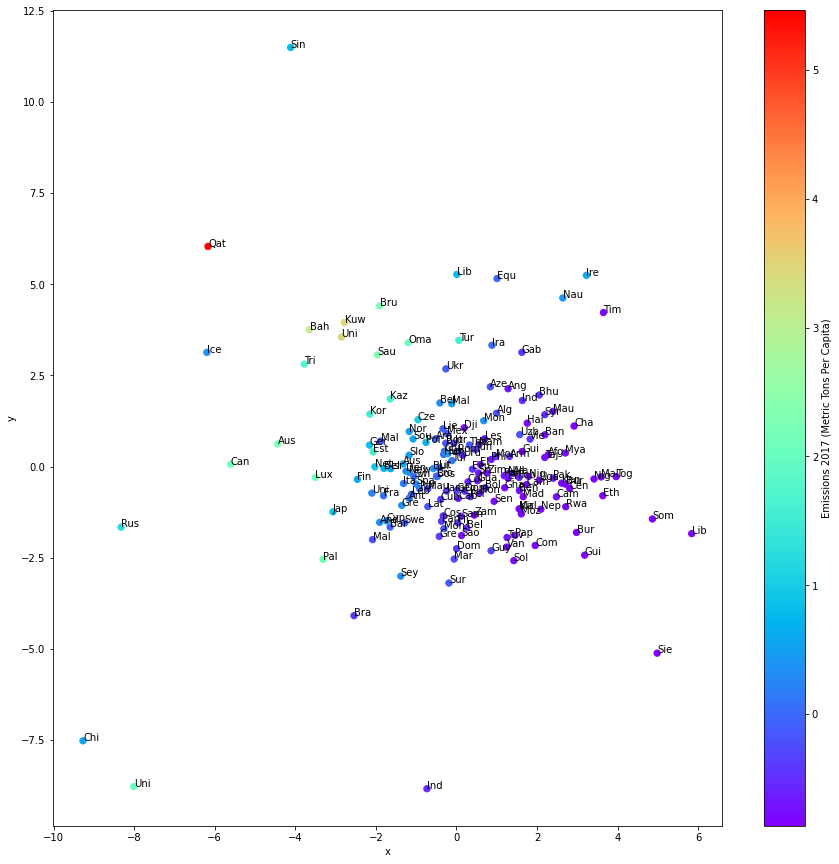

In [19]:
## Plot the 2D data
data2D_v = data2D.join(norm['Emissions 2017 (Metric Tons Per Capita)'])
data2D_v.head()
ax = data2D_v.plot.scatter('x', 'y', c='Emissions 2017 (Metric Tons Per Capita)', 
                           s=40, colormap=plt.cm.rainbow, figsize=(15,15), sharex=False)
# ax.axis('scaled')
for i,r in data2D.iterrows():
   ax.text(r.x, r.y, i[0:3])

,K,Inertia
6,7,950.263529


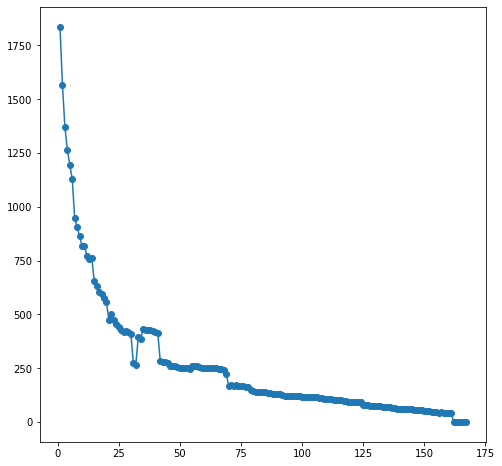

In [20]:
# Let's Cluster the data to see how we can group countries together. 
# First, let's find the optimal number of clusters. 

kVals = []
twcv = []
for k in range(1, len(norm)):
    centroids = norm.iloc[0:k]
    km = sklearn.cluster.KMeans(n_clusters=k, init=centroids, n_init=1, max_iter=10)
    km.fit(norm)
    kVals.append(k)
    twcv.append(km.inertia_)
d = {'K': kVals, 'Inertia': twcv}
Answer2 = pandas.DataFrame(data=d)
plt.figure(figsize=(8, 8))
plt.plot(Answer2.K, Answer2.Inertia, marker='o')
Answer2[Answer2.K == 7]

In [21]:
# It looks like there's a steep drop in within-cluster variance just around K = 7. 
# Choosing more clusters will make it more difficult to meaningfully group countries, so 
# let's choose 7 clusters for now. 
km = sklearn.cluster.KMeans(n_clusters=7)
labels = km.fit_predict(norm)
# labels
labels = pandas.DataFrame(labels, columns=['Cluster'], index=norm.index)
labels

# labels.sort_values('Cluster')

,Cluster
country,
Afghanistan,3
Albania,3
Algeria,0
Andorra,6
Angola,0
...,...
Uzbekistan,0
Vanuatu,3
Vietnam,0


(-10.026644355069928, 6.597983376383878, -9.854841615266118, 12.51443857405282)

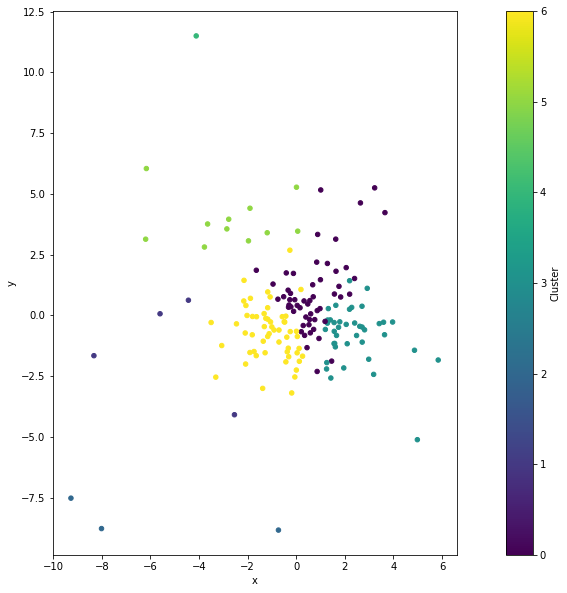

In [22]:
# Now, let's plot the results of the clustering. 
data2DClustered = data2D.join(labels.Cluster)
data2DClustered
ax = data2DClustered.plot.scatter('x', 'y', c='Cluster', colormap=plt.cm.viridis, figsize=(10, 10), sharex=False)
ax.axis('scaled')
# for i,r in data2D.iterrows():
#     ax.text(r.x, r.y, i)

## Question: Does a Country's Population or Land Area have anything to do with greenhouse emissions? (Atharva)

Does population or land area affect the volume of greenhouse emissions? By determining a correlation between these variables, we can better determine which countries are major contributors of greenhouse emissions. For example, if population and greenhouse emissions are strongly correlated together, then we can focus on countries with large populations, since those nations will have the greatest influence over the global volume of emissions. Furthermore, we'll get a better sense geographically for which countries are major contributors of emissions.  

Hypothesis 1: We should expect countries with larger populations to emit more CO2 into the atmosphere. This will most likely be the case, since a larger population typically consumes more energy than a smaller population. Many countries meet their energy needs by burning coal or fossil fuels, and these sources of energy release CO2 into the atmosphere. 
  
  
Hypothesis 2: Countries with larger land areas will, on average, emit more CO2 into the atmosphere than smaller countries. Many of the major exporters of the world are nations which have a large surface area, and countries which have more economic activity would most likely release greater amounts of CO2 than countries with less active economies.

In order to answer this question, data from https://www.kaggle.com/datasets/sudalairajkumar/undata-country-profiles will be utilized. This data contains general information about each of the countries as well as social, economic, and environmental indicators. The dataset was extracted from information published by the United Nations, so it is a good authoritative source. 

Before analyzing the data, it will be helpful to define what units population, land area, and greenhouse emissions are measured in. Population will be measured in thousands of people, land area will be measured in square kilometers, and greenhouse emissions will be quantified in million tons / tons per capita.  

Throughout this report, the only major bias present in our work is that the authors of this report believe that human activity has altered Earth's climate system and that an excess amount of greenhouse gases in the atmosphere can have a negative effect on the environment. 

## Analysis: 
First we import some libraries that we will need. Pandas is a general purpose data analysis library and numpy is useful for certain mathematical operations, like matrix multiplications. The sklearn.linear_model module will allow for a linear regression line to be fitted to the given data. 

In [23]:
import pandas
import numpy
from sklearn.linear_model import LinearRegression

Let's use the countryStats dataset from the clustering analysis above. It contains all the relevant columns and is already cleaned, so we can begin right away with visualization and analysis.  

Below are 2-D scatterplots which show the relationships between Surface Area vs. CO2 emissions and Population (thousands) vs. CO2 emissions

<AxesSubplot:xlabel='Population in thousands (2017)', ylabel='Raw Emissions (Million Metric Tons)'>

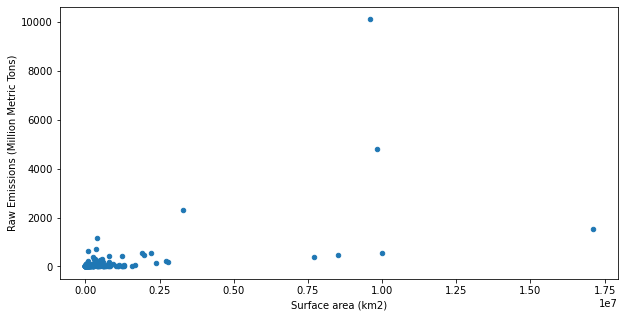

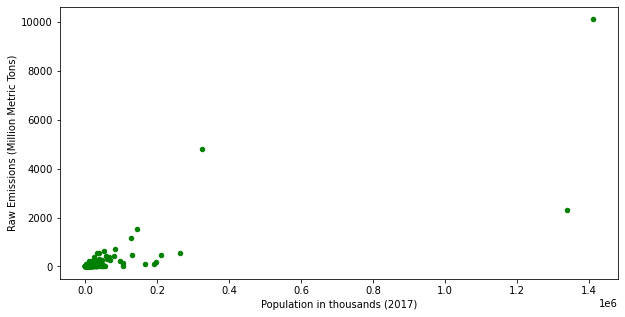

In [24]:
# Let's add a column for raw emissions. 
countryStats['Raw Emissions (Million Metric Tons)'] = countryStats['Emissions 2017 (Metric Tons Per Capita)'] * countryStats['Population in thousands (2017)'] / 1000
countryStats.plot.scatter(x='Surface area (km2)', y='Raw Emissions (Million Metric Tons)', figsize=(10,5))
countryStats.plot.scatter(x='Population in thousands (2017)', y='Raw Emissions (Million Metric Tons)', color='green', figsize=(10,5))

Now, let's compute the Pearson Correlation Coefficients for Surface Area vs. Raw CO2 emissions and for Population (thousands) vs. Raw CO2 emissions.

In [25]:
countryStats['Surface area (km2)'].corr(countryStats['Raw Emissions (Million Metric Tons)'])

0.5791811207375188

In [26]:
countryStats['Population in thousands (2017)'].corr(countryStats['Raw Emissions (Million Metric Tons)'])

0.817166051394942

We get a fairly strong correlation coefficient for Population vs. CO2 Emissions. The correlation coefficient for Surface area vs. CO2 is slightly weaker, probably due to outliers. Let's see what happens if we remove these outliers. 

In [27]:
countryStatsNoOutliers = countryStats[countryStats['Raw Emissions (Million Metric Tons)'] < 4000]
countryStatsNoOutliers['Surface area (km2)'].corr(countryStatsNoOutliers['Raw Emissions (Million Metric Tons)'])

0.5747403553425343

Interestingly, we get about the same correlation coefficient. It looks like the outliers didn't really affect the Pearson coefficient.  
Let's create a 3-D visualization of the data with Surface area and Population on the x and y axes and CO2 emissions on the z axis. 

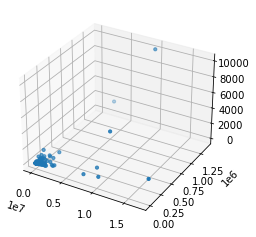

In [28]:
# Graphing libraries
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(countryStats['Surface area (km2)'], countryStats['Population in thousands (2017)'], countryStats['Raw Emissions (Million Metric Tons)'], 
                s=10)


In [29]:
# %matplotlib auto

Now, what happens if we do a multiple linear regression analysis using both surface area and population as independent variables?

In [30]:
X = countryStats[['Surface area (km2)','Population in thousands (2017)']]
lm = LinearRegression().fit(X, countryStats['Raw Emissions (Million Metric Tons)'])
lm.coef_,lm.intercept_
multiRegR = (lm.score(X, countryStats['Raw Emissions (Million Metric Tons)']))**0.5
multiRegR

0.8520004023926339

Our multiple linear regression model gives an R-value of ~0.85, which is better than both of the individual R-values. 

Read in the original country profile data

In [31]:
# Read the original data into a pandas dataframe. 
dirty = pandas.read_csv("country_profile_variables.csv")

Here's a glance at the data:   

In [32]:
dirty.head()

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,SouthernAsia,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,...,8.3,42,2.1,9.8/0.3,63,5,78.2/47.0,45.1/27.0,21.43,-99
1,Albania,SouthernEurope,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,...,63.3,130,28.2,5.7/2.0,84,36,94.9/95.2,95.5/90.2,2.96,-99
2,Algeria,NorthernAfrica,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,...,38.2,135,0.8,145.4/3.7,5900,55,84.3/81.8,89.8/82.2,0.05,-99
3,American Samoa,Polynesia,199,56,278.2,103.6,-99,-99,-99.0,-99,...,-99,92,87.9,-99,-99,-99,100.0/100.0,62.5/62.5,-99,-99
4,Andorra,SouthernEurope,468,77,163.8,102.3,2812,0.8,39896.4,0.5,...,96.9,13,34.0,0.5/6.4,1,119,100.0/100.0,100.0/100.0,-99,-99


These are the data types. Notice how the Surface area (km2) column has an object data type. We should probably clean this column so the data is in a more useful form. 

In [33]:
dirty.dtypes

country                                                        object
Region                                                         object
Surface area (km2)                                             object
Population in thousands (2017)                                  int64
Population density (per km2, 2017)                            float64
Sex ratio (m per 100 f, 2017)                                 float64
GDP: Gross domestic product (million current US$)               int64
GDP growth rate (annual %, const. 2005 prices)                 object
GDP per capita (current US$)                                  float64
Economy: Agriculture (% of GVA)                                object
Economy: Industry (% of GVA)                                  float64
Economy: Services and other activity (% of GVA)               float64
Employment: Agriculture (% of employed)                        object
Employment: Industry (% of employed)                           object
Employment: Services

Before doing any further analysis, we retain a copy of the original data. This way, we can track any modifications we choose to make. 

In [34]:
# Make a copy of the original dataframe and process data for analysis
clean = dirty.copy()

Clean the data by taking out the ~ symbol  
Note: For computation purposes, we will treat countries that have a really small land area (~0) as having no land area, even though this is clearly not the case. 

In [35]:
clean['Surface area (km2)'] = dirty['Surface area (km2)'].map(lambda val: int(val.replace('~', '')))

Some countries have a land area < 0 or emission estimates that are < 0. 

In [36]:
# Remove countries that meet this criteria. 
clean[clean['Surface area (km2)'] < 0]
clean[clean['CO2 emission estimates (million tons/tons per capita)'] < 0]

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
3,American Samoa,Polynesia,199,56,278.2,103.6,-99,-99,-99.0,-99,...,-99,92,87.9,-99,-99,-99,100.0/100.0,62.5/62.5,-99,-99
7,Antigua and Barbuda,Caribbean,442,102,231.8,92.3,1356,4.1,14764.5,1.9,...,65.2,55,22.3,0.5/5.8,-99,84,97.9/97.9,91.4/91.4,0.12,-99
38,Cayman Islands,Caribbean,264,62,256.5,100.4,3726,0.7,62132.0,0.3,...,77.0,74,52.9,0.5/9.2,-99,130,97.4/...,95.6/...,-99,-99
41,Channel Islands,NorthernEurope,180,165,870.1,98.4,-99,-99,-99.0,-99,...,-99,-99,4.2,-99,-99,-99,-99,-99,-99,-99
43,"China, Hong Kong SAR",EasternAsia,1106,7365,7014.2,85.1,309236,2.4,42431.0,0.1,...,84.9,64,-99,46.2/6.4,-99,83,-99,-99,-99,-99
49,Cook Islands,Polynesia,236,17,72.4,97.4,294,5.5,14118.7,8.1,...,-99,75,62.9,0.1/3.4,-99,48,99.9/99.9,97.6/97.6,-99,-99
80,Gibraltar,SouthernEurope,6,35,3457.1,101.8,-99,-99,-99.0,-99,...,65.0,31,0.0,0.5/16.5,-99,259,-99,-99,-99,-99
85,Guam,Micronesia,549,164,304.1,102.6,-99,-99,-99.0,-99,...,73.1,99,46.3,-99,-99,-99,99.5/99.5,89.8/89.8,-99,-99
91,Holy See,SouthernEurope,0,1,1800.0,219.2,-99,-99,-99.0,-99,...,-99,1,-99,-99,-99,-99,-99,-99,-99,-99
133,Monaco,WesternEurope,2,39,25969.8,94.7,6258,5.4,165870.6,-99,...,93.4,21,-99,-99,-99,-99,100.0/...,100.0/...,-99,-99


We will filter out rows that have a negative Surface area (km2) or negative CO2 emission estimates.  
The UN likely didn't have accurate data on those countries

In [37]:
nonNegSA = clean[clean['Surface area (km2)'] >= 0]
filtClean = nonNegSA[nonNegSA['CO2 emission estimates (million tons/tons per capita)'] >= 0]

Sanity check: We would expect that 20 rows are filtered out based on the emission estimates column and 3 rows are filtered out based on surface area. That gives 229 rows - 23 rows = 206 rows. 

In [38]:
filtClean.shape

(206, 50)

In [39]:
filtClean.head()

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,SouthernAsia,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,...,8.3,42,2.1,9.8/0.3,63,5,78.2/47.0,45.1/27.0,21.43,-99
1,Albania,SouthernEurope,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,...,63.3,130,28.2,5.7/2.0,84,36,94.9/95.2,95.5/90.2,2.96,-99
2,Algeria,NorthernAfrica,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,...,38.2,135,0.8,145.4/3.7,5900,55,84.3/81.8,89.8/82.2,0.05,-99
4,Andorra,SouthernEurope,468,77,163.8,102.3,2812,0.8,39896.4,0.5,...,96.9,13,34.0,0.5/6.4,1,119,100.0/100.0,100.0/100.0,-99,-99
5,Angola,MiddleAfrica,1246700,29784,23.9,96.2,117955,3.0,4714.1,6.8,...,12.4,146,46.5,34.8/1.4,3902,25,75.4/28.2,88.6/22.5,0.42,-99


Now that the data is thoroughly cleaned, we can begin visualization and analysis.  
We first create scatterplots for both Surface Area vs. CO2 emissions and Population (thousands) vs. CO2 emissions

<AxesSubplot:xlabel='Population in thousands (2017)', ylabel='CO2 emission estimates (million tons/tons per capita)'>

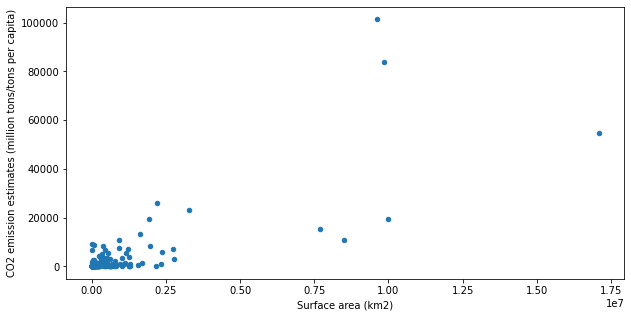

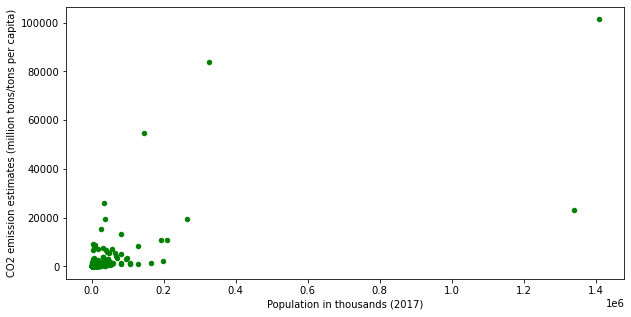

In [40]:
filtClean.plot.scatter(x='Surface area (km2)', y='CO2 emission estimates (million tons/tons per capita)', figsize=(10,5))
filtClean.plot.scatter(x='Population in thousands (2017)', y='CO2 emission estimates (million tons/tons per capita)', color='green', figsize=(10,5))

Then, we compute the Pearson correlation coefficients for Surface Area vs. CO2 emissions and for Population (thousands) vs. CO2.  

In [41]:
filtClean['Surface area (km2)'].corr(filtClean['CO2 emission estimates (million tons/tons per capita)'])

0.7781603436900913

In [42]:
filtClean['Population in thousands (2017)'].corr(filtClean['CO2 emission estimates (million tons/tons per capita)'])

0.6973538601474337

These R values are both near or in the 0.70-0.80 range, so they indicate a relatively good linear fit.  
Let's go ahead and create a linear regression model for both pairs of x,y data. 

In [43]:
# Fit the Surface Area vs. CO2 emissions data to a linear regression model. 
lmSA = LinearRegression().fit(filtClean[['Surface area (km2)']], filtClean[['CO2 emission estimates (million tons/tons per capita)']])
lmSA.coef_, lmSA.intercept_

(array([[0.00432998]]), array([-66.57587138]))

In [44]:
# Fit the Population (thousands) vs. CO2 emissions data to a linear regression model. 
lmPop = LinearRegression().fit(filtClean[['Population in thousands (2017)']], filtClean[['CO2 emission estimates (million tons/tons per capita)']])
lmPop.coef_, lmPop.intercept_

(array([[0.05184319]]), array([870.37176209]))

Create a new data table which has a column for predicted CO2 levels with the SA vs. CO2 data

In [45]:
# Used assign() to create a new DataFrame with the Predicted_CO2 column because of the 
# SettingWithCopy warning. 

# Create a predictedCO2 column for Surface Area
predictedCO2 = filtClean['Surface area (km2)']*lmSA.coef_[0] + lmSA.intercept_
filtCleanSA = filtClean.assign(Predicted_CO2 = predictedCO2)
filtCleanSA.head()

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI),Predicted_CO2
0,Afghanistan,SouthernAsia,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,...,42,2.1,9.8/0.3,63,5,78.2/47.0,45.1/27.0,21.43,-99,2760.310369
1,Albania,SouthernEurope,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,...,130,28.2,5.7/2.0,84,36,94.9/95.2,95.5/90.2,2.96,-99,57.902313
2,Algeria,NorthernAfrica,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,...,135,0.8,145.4/3.7,5900,55,84.3/81.8,89.8/82.2,0.05,-99,10246.308376
4,Andorra,SouthernEurope,468,77,163.8,102.3,2812,0.8,39896.4,0.5,...,13,34.0,0.5/6.4,1,119,100.0/100.0,100.0/100.0,-99,-99,-64.549442
5,Angola,MiddleAfrica,1246700,29784,23.9,96.2,117955,3.0,4714.1,6.8,...,146,46.5,34.8/1.4,3902,25,75.4/28.2,88.6/22.5,0.42,-99,5331.606715


Do the same, except for the Pop. (thousands) vs. CO2 data

In [46]:
# Create a predictedCO2 column for Population
predictedCO2 = filtClean['Population in thousands (2017)']*lmPop.coef_[0] + lmPop.intercept_
filtCleanPop = filtClean.assign(Predicted_CO2 = predictedCO2)
filtCleanPop.head()

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI),Predicted_CO2
0,Afghanistan,SouthernAsia,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,...,42,2.1,9.8/0.3,63,5,78.2/47.0,45.1/27.0,21.43,-99,2712.360334
1,Albania,SouthernEurope,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,...,130,28.2,5.7/2.0,84,36,94.9/95.2,95.5/90.2,2.96,-99,1022.272311
2,Algeria,NorthernAfrica,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,...,135,0.8,145.4/3.7,5900,55,84.3/81.8,89.8/82.2,0.05,-99,3012.428723
4,Andorra,SouthernEurope,468,77,163.8,102.3,2812,0.8,39896.4,0.5,...,13,34.0,0.5/6.4,1,119,100.0/100.0,100.0/100.0,-99,-99,874.363688
5,Angola,MiddleAfrica,1246700,29784,23.9,96.2,117955,3.0,4714.1,6.8,...,146,46.5,34.8/1.4,3902,25,75.4/28.2,88.6/22.5,0.42,-99,2414.469359


Visualize the results.  
Overlay the actual data with the predicted data for both x,y pairs. 

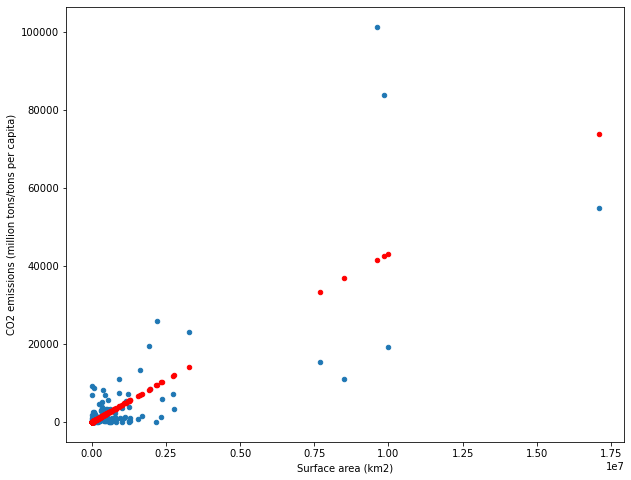

In [47]:
# Overlay the predicted CO2 levels on the plot with actual Surface Area vs. CO2 data. 
axSA = filtCleanSA.plot.scatter(x='Surface area (km2)', y='CO2 emission estimates (million tons/tons per capita)', figsize=(10,8))
filtCleanSA.plot.scatter(x='Surface area (km2)', y='Predicted_CO2', ax=axSA, color='red')
axSA = axSA.set_ylabel('CO2 emissions (million tons/tons per capita)')

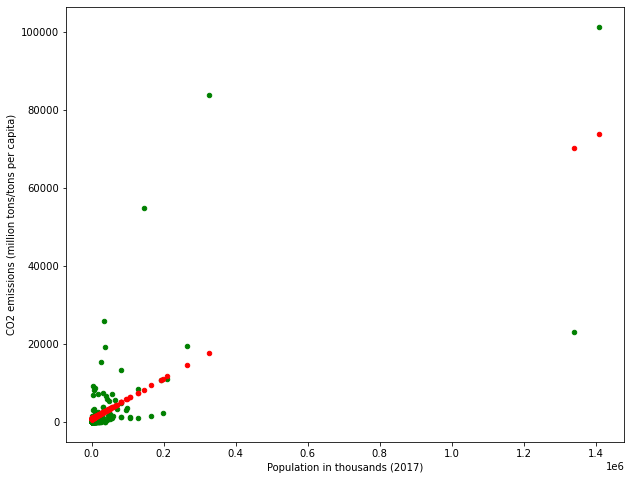

In [48]:
# Visualization Population (thousands) vs. CO2 data
axPop = filtCleanPop.plot.scatter(x='Population in thousands (2017)', y='CO2 emission estimates (million tons/tons per capita)', color='green', figsize=(10,8))
filtCleanPop.plot.scatter(x='Population in thousands (2017)', y='Predicted_CO2', ax=axPop, color='red')
axPop = axPop.set_ylabel('CO2 emissions (million tons/tons per capita)')

Make sure the regression models are consistent with what we would expect. 

In [49]:
# Checkpoint: Verify the predicted columns are correct. 
filtCleanSA['Surface area (km2)'].corr(filtCleanSA['Predicted_CO2']), filtCleanPop['Population in thousands (2017)'].corr(filtCleanPop['Predicted_CO2'])

(0.9999999999999998, 1.0)

## Conclusion:

From the above analysis, it appears that land area and population do have some relation to CO2 emissions. In both cases, there is a positive correlation with a small slope. As surface area increases by 1 km^2, the model predicts an increase of 4.33*10^-3 millions of tons of CO2 / tons per capita. Similarly, as population increases by a thousand people, the model indicates that there should be about an increase of 0.052 millions of tons of CO2 / tons per capita. According to the linear regression model, countries which have a larger surface area on average produce more CO2 emissions. Likewise, countries which have a greater population on average produce more CO2 than countries with smaller populations. These results support both of the hypotheses stated above. 

However, the models created in the analysis section are only approximations and leave out important information. From the graph of Surface Area (km2) vs. CO2 emissions, we can see a few countries which emit a substantially larger volume of CO2 than other nations. These countries also lie above the regression line for both plots, which means they emit more CO2 than the models predict. 

One additional question that can be explored is whether population density is a better predictor of CO2 emissions than total population. A large population density value could be associated with urban areas and cities, and may therefore have a strong correlation with CO2 emissions. Another potential question to consider is whether CO2 emissions can be better predicted using both surface area and population as independent variables. This would require a multiple linear regression analysis. Finally, while the CO2 emissions from this dataset are normalized by population (e.g. divided by tons per capita), it may be worth considering what effect population and surface area have on raw CO2 emissions, for example in units of cubic meters. 

## Question: Is there a correlation between GDP and greenhouse gas emissions? (Justin)

Does GDP affect the volume of greenhouse emissions? By determining a correlation between these variables, we can better determine how a country's economy affects its CO2 emissions. We would expect countries with larger economies, and therefore larger GDPs, to produce more CO2 emissions, due to more energy demands and pollution from factories. 

In order to answer this question, data from https://www.kaggle.com/datasets/sudalairajkumar/undata-country-profiles will be utilized. This data contains general information about each of the countries as well as social, economic, and environmental indicators. The dataset was extracted from information published by the United Nations, so it is a good authoritative source. 

Before analyzing the data, it will be helpful to define what units GDP and greenhouse emissions are measured in. GDP will be measured in GDP per capita, in USD. CO2 emissions will be quantified in million tons / tons per capita. GDP per capita will be used instead of raw GDP, since CO2 emissions are already measured per person, so both variables will be scaled in the same way. 

## Analysis: 
We'll use numpy, pandas, and matplotlib to analyze the data. We'll also use the sklearn.linear_model module to fit a linear regression model if there is a correlation.

Here, we'll compare GDP per capita to CO2 emissions per capita. This is because both variables are measured per person, and thus are scaled the same relative to each country. 

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy

We'll start by reading in our data.

In [51]:
dirty = pd.read_csv("country_profile_variables.csv")

Preview the data to see what the data looks like and the data types.

In [52]:
dirty.head()

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,SouthernAsia,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,...,8.3,42,2.1,9.8/0.3,63,5,78.2/47.0,45.1/27.0,21.43,-99
1,Albania,SouthernEurope,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,...,63.3,130,28.2,5.7/2.0,84,36,94.9/95.2,95.5/90.2,2.96,-99
2,Algeria,NorthernAfrica,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,...,38.2,135,0.8,145.4/3.7,5900,55,84.3/81.8,89.8/82.2,0.05,-99
3,American Samoa,Polynesia,199,56,278.2,103.6,-99,-99,-99.0,-99,...,-99,92,87.9,-99,-99,-99,100.0/100.0,62.5/62.5,-99,-99
4,Andorra,SouthernEurope,468,77,163.8,102.3,2812,0.8,39896.4,0.5,...,96.9,13,34.0,0.5/6.4,1,119,100.0/100.0,100.0/100.0,-99,-99


Lets extract the GDP and CO2 emissions data from the original dataset into one clean dataframe.

In [53]:
clean = pd.DataFrame()

# copy 'GDP per capita (current US$)' and ''CO2 emission estimates (million tons/tons per capita)'
clean['Country'] = dirty['country']
clean['Region'] = dirty['Region']
clean['CO2 emission estimates (million tons/tons per capita)'] = dirty['CO2 emission estimates (million tons/tons per capita)']
clean['GDP per capita (current US$)'] = dirty['GDP per capita (current US$)']
clean.head()

,Country,Region,CO2 emission estimates (million tons/tons per capita),GDP per capita (current US$)
0,Afghanistan,SouthernAsia,63,623.2
1,Albania,SouthernEurope,84,3984.2
2,Algeria,NorthernAfrica,5900,4154.1
3,American Samoa,Polynesia,-99,-99.0
4,Andorra,SouthernEurope,1,39896.4


There seems to be a lot of missing data in the both columns, here labeled with -99. We'll remove all rows with missing data.

In [54]:
# remove rows with values less than 0
clean = clean[clean['CO2 emission estimates (million tons/tons per capita)'] >= 0]
clean = clean[clean['GDP per capita (current US$)'] >= 0]
clean.head()

,Country,Region,CO2 emission estimates (million tons/tons per capita),GDP per capita (current US$)
0,Afghanistan,SouthernAsia,63,623.2
1,Albania,SouthernEurope,84,3984.2
2,Algeria,NorthernAfrica,5900,4154.1
4,Andorra,SouthernEurope,1,39896.4
5,Angola,MiddleAfrica,3902,4714.1


We removed some rows. Lets count the number of missing rows.

In [55]:
dirty.shape[0] - clean.shape[0]

31

Lets plot the data.

<AxesSubplot:xlabel='CO2 emission estimates (million tons/tons per capita)', ylabel='GDP per capita (current US$)'>

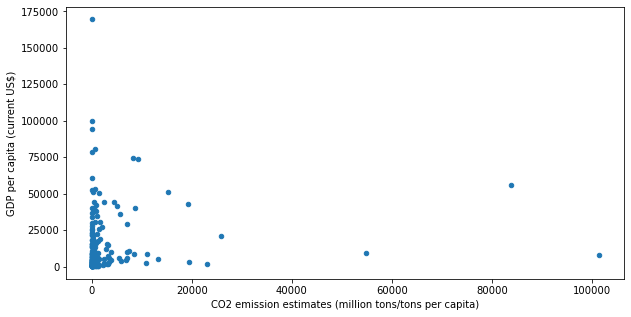

In [56]:
# plot CO2 emission estimates vs. GDP per capita
clean.plot.scatter(x='CO2 emission estimates (million tons/tons per capita)', y='GDP per capita (current US$)', figsize=(10,5))

This plot is not too helpful, there seems to be a lot of crowded points close to zero. Lets zoom in closer to zero to get a better understanding of the plot.

<AxesSubplot:xlabel='CO2 emission estimates (million tons/tons per capita)', ylabel='GDP per capita (current US$)'>

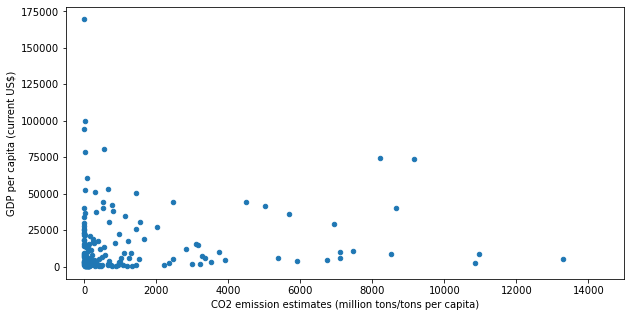

In [57]:
# plot, limit x to 15000
clean.plot.scatter(x='CO2 emission estimates (million tons/tons per capita)', y='GDP per capita (current US$)', figsize=(10,5), xlim=(-500,15000))

To the eye, there does not seem to be a correlation. Lets compute Pearson's coeffecient.

In [58]:
# compute r
clean['CO2 emission estimates (million tons/tons per capita)'].corr(clean['GDP per capita (current US$)'])

0.09252113051856786

## Conclusion:

There is no correlation between GDP and CO2 emissions. This could be because GDP is not a good predictor of CO2 emissions, or because the data is not representative of the real world.

If our result is true, it could mean that CO2 emissions do not have any relationship with GDP. This could mean that countries with lots of exports do not have high CO2 emissions, and that they might rely on other countries for energy and other needs which produce CO2.

This hypothesis could be true due to the amount of outliers we see on our plot. Most countries have low CO2 emissions with the exception of a few countries with very high CO2 emissions.

## Question: What forms of government do the countries that produce the most greenhouse gases have? (Atharva)
What forms of government do nations which are major emitters of greenhouse gases have? By answering this question, we may be able to gain insight into whether certain forms of government are more effective than others in terms of reducing emissions. 

Data for this question will be taken taken from https://cddrl.fsi.stanford.edu/research/autocracies_of_the_world_dataset and https://worldpopulationreview.com/country-rankings/greenhouse-gas-emissions-by-country. 

The Stanford Center on Democracy, Development, and the Rule of Law is responsible for producing the first dataset. This dataset includes information on countries and their forms of government through the years 1950-2012. While this data might seem to be somewhat outdated, only data from 2012 will be analyzed. Furthermore, most governments throughout the world have remained stable for at least the last 10 years, so we expect the data to be accurate. In this dataset, government types are grouped into 5 categories: Democracy, Military, Monarchy, Multiparty, and Single Party. 

The second link lists out countries and their CO2 emissions in millions of tons. The world population review site was responsible for collecting this data, and we expect it to be both accurate and reliable. The data is also current, since it was taken in 2022. 

## Analysis: 
First, let's import both datasets and get a sense of what the data looks like. 

In [59]:
dirtyGovt = pd.read_excel("countries_by_govt.xls")
dirtyEmissions = pd.read_csv("emissions_Mt_country_2022.csv")

In [60]:
dirtyGovt.head()

,cyear,cntyr,ccode,scode,country,year,un_region,un_continent,reg_id,demo_nr,...,duration_r,personal,personal2,lindex,exname,change,tdate,trans,occup,interreg
0,21950,United States 1950,2,USA,United States,1950,Northern America,Americas,201.0,1.0,...,141.0,NaN,NaN,NaN,Harry Truman,0.0,07.04.1776,0.0,0.0,0.0
1,21951,United States 1951,2,USA,United States,1951,Northern America,Americas,201.0,1.0,...,142.0,NaN,NaN,NaN,Harry Truman,0.0,NaN,0.0,0.0,0.0
2,21952,United States 1952,2,USA,United States,1952,Northern America,Americas,201.0,1.0,...,143.0,NaN,NaN,NaN,Harry Truman,0.0,NaN,0.0,0.0,0.0
3,21953,United States 1953,2,USA,United States,1953,Northern America,Americas,201.0,1.0,...,144.0,NaN,NaN,NaN,Dwight D. Eisenhower,0.0,NaN,0.0,0.0,0.0
4,21954,United States 1954,2,USA,United States,1954,Northern America,Americas,201.0,1.0,...,145.0,NaN,NaN,NaN,Dwight D. Eisenhower,0.0,NaN,0.0,0.0,0.0


In [61]:
dirtyEmissions.head()

,country,totalCO2emission,pop2022
0,CHINA,2806634,1448471.400
1,UNITED STATES,1432855,334805.269
2,INDIA,610411,1406631.776
3,RUSSIA,465052,145805.947
4,JAPAN,331074,125584.838


Here we display the shape of the data as well as the data types present. 

In [62]:
dirtyGovt.shape
dirtyGovt.dtypes

cyear             int64
cntyr            object
ccode             int64
scode            object
country          object
year              int64
un_region        object
un_continent     object
reg_id          float64
demo_nr         float64
demo_r          float64
regime_r         object
regime_nr        object
duration_nr     float64
duration_r      float64
personal        float64
personal2       float64
lindex          float64
exname           object
change          float64
tdate            object
trans           float64
occup           float64
interreg        float64
dtype: object

In [63]:
dirtyEmissions.shape
dirtyEmissions.dtypes

country              object
totalCO2emission      int64
pop2022             float64
dtype: object

First, let's make a copy of the DataFrames. This will allow us to refer back to the original data if necessary. 

In [64]:
# Make a copy of the original dataframe and process data for analysis
newEmissions = dirtyEmissions.copy()
newGovt = dirtyGovt.copy()

Let's filter out all rows in newGovt which have years other than 2012. 

In [65]:
# Filter by year (only 2012)
newGovt2012 = newGovt[newGovt.year == 2012]
newGovt2012

,cyear,cntyr,ccode,scode,country,year,un_region,un_continent,reg_id,demo_nr,...,duration_r,personal,personal2,lindex,exname,change,tdate,trans,occup,interreg
62,22012,United States 2012,2,USA,United States,2012,Northern America,Americas,201.0,1.0,...,203.0,NaN,NaN,NaN,Barack Obama,0.0,NaN,0.0,0.0,0.0
125,202012,Canada 2012,20,CAN,Canada,2012,Northern America,Americas,2001.0,1.0,...,81.0,NaN,NaN,NaN,Stephen Joseph Harper,0.0,NaN,0.0,0.0,0.0
188,402012,Cuba 2012,40,CUB,Cuba,2012,Caribbean,Americas,4004.0,0.0,...,54.0,1.0,1.0,0.774348,Raul Castro,0.0,NaN,0.0,0.0,0.0
251,412012,Haiti 2012,41,HAI,Haiti,2012,Caribbean,Americas,4107.0,0.0,...,18.0,NaN,0.0,0.368421,Michel Martelly,0.0,NaN,0.0,0.0,1.0
314,422012,Dominican Republic 2012,42,DOM,Dominican Republic,2012,Caribbean,Americas,4206.0,1.0,...,34.0,NaN,NaN,NaN,Danilo Medina,0.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8449,9002012,Australia 2012,900,AUL,Australia,2012,Australia and New Zealand,Oceania,90001.0,1.0,...,112.0,NaN,NaN,NaN,Julia Gillard,0.0,NaN,0.0,0.0,0.0
8487,9102012,Papua New Guinea 2012,910,PNG,Papua New Guinea,2012,Melanesia,Oceania,91001.0,1.0,...,37.0,NaN,NaN,NaN,Peter O'Neill,0.0,NaN,0.0,0.0,0.0
8550,9202012,New Zealand 2012,920,NEW,New Zealand,2012,Australia and New Zealand,Oceania,92001.0,1.0,...,65.0,NaN,NaN,NaN,John Phillip Key,0.0,NaN,0.0,0.0,0.0
8585,9402012,Solomon Islands 2012,940,SOL,Solomon Islands,2012,Melanesia,Oceania,94001.0,1.0,...,34.0,NaN,NaN,NaN,Gordon Darcy Lilo,0.0,NaN,0.0,0.0,0.0


Are there any missing or negative values for the columns we're interested in? 

In [66]:
len(newEmissions[newEmissions.totalCO2emission < 0])
newGovt2012.country.isnull().values.any()
newGovt2012.regime_nr.isnull().values.any()

False

It looks like we are ok to proceed with visualization and analysis. The data types seem to be consistent, and there are no missing or outlier values in the columns we care about.  
First, let's join the relevant columns from both of these tables together. 

In [67]:
# First make sure the primary key columns are consistent for both tables. 
countryUpper = [c.upper() for c in newGovt2012.country]
len(countryUpper)
govt2012 = newGovt2012.assign(country_upper = countryUpper)

In [68]:
govt2012.head(10)
govt2012.shape

(167, 25)

In [69]:
# Now, join by country name. 
joinedData = pandas.merge(govt2012, newEmissions, how='inner', left_on='country_upper', right_on='country')
joinedData.shape

(155, 28)

An inner join was used in order to ensure that no values will be NaN in the newly formed table. Now that we've joined, we can filter out the columns which aren't relevant. 

In [70]:
joinedData = joinedData[['country_x', 'regime_nr', 'totalCO2emission']]
joinedData.shape
joinedData.head()

,country_x,regime_nr,totalCO2emission
0,United States,Democracy,1432855
1,Canada,Democracy,146494
2,Cuba,Single Party,9500
3,Haiti,Multiparty,780
4,Dominican Republic,Democracy,5874


It looks like we haven't lost any rows, so all the data from the joined table for each of these columns should be present.  
Let's now do a groupby on government type. 

In [71]:
g = joinedData.groupby('regime_nr')
g.size()

regime_nr
Democracy       88
Military         7
Monarchy         8
Multiparty      45
Single Party     7
dtype: int64

The next step is to aggregate data for the groupby object we have generated. Let's first try taking the mean of the CO2 emissions for each of these columns. 

In [72]:
g.totalCO2emission.mean()

regime_nr
Democracy        53514.113636
Military          1565.428571
Monarchy         40717.875000
Multiparty       21685.200000
Single Party    436878.285714
Name: totalCO2emission, dtype: float64

It looks like countries which have a single party government have a large mean of CO2 emissions. Perhaps this is because there are outlier countries, like China. Let's take the median, which is less prone to outliers, and see if our results differ. 

In [73]:
g.totalCO2emission.median()

regime_nr
Democracy        9371.5
Military          385.0
Monarchy        21349.5
Multiparty       2675.0
Single Party    18659.0
Name: totalCO2emission, dtype: float64

Median results give more insight into what may be going on. Democracies, Monarchies, and Single Party states appear to emit more CO2 emissions than nations which have Military governments or Multiparty systems. However, based on the differences between the mean and median, Single Party states and Democracies contain a few outlier countries which emit a lot more CO2 than the rest.  
  
  Let's now visualize the results. 

<AxesSubplot:xlabel='country_x'>

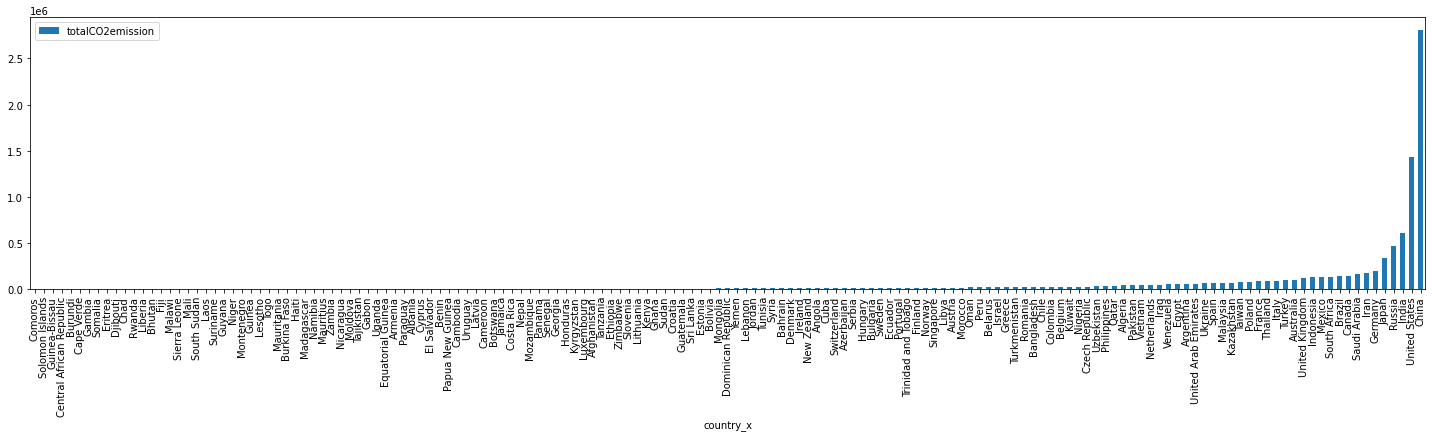

In [74]:
joinedData.sort_values('totalCO2emission').plot.bar('country_x', 'totalCO2emission', figsize=(25,5))

Due to the large number of countries, let's focus on the countries which are major emitters. 

In [75]:
majorEmitters = joinedData[joinedData.totalCO2emission > 20000]
majorEmitters.shape

(43, 3)

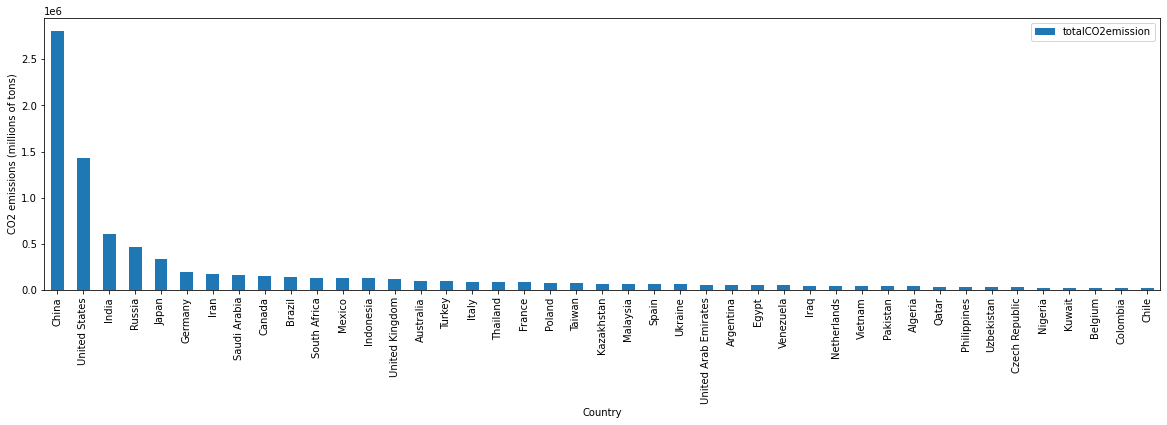

In [76]:
axP3 = majorEmitters.sort_values('totalCO2emission', ascending=False).plot('country_x', 'totalCO2emission', 
                                                                    kind='bar', figsize=(20,5))
axP3 = axP3.set(xlabel='Country', ylabel='CO2 emissions (millions of tons)')


As predicted, a few countries that emit a lot of CO2, like China and the United States, impact the mean for Single Party systems and Democracies significantly. 

## Conclusion: 


Of the five types of governmental systems in the Stanford dataset, it appears that Democracies, Single Party states, and Monarchies emit more CO2 into the atmosphere than Military states and Multiparty systems. However, as seen from the bar graph, a few countries emit substantially more CO2 than the vast majority of other nations. These include China, The United States, and India. In fact, China emits about 2x as much CO2 as the US, which in turn emits more than 2x as much CO2 as India. Countries like China and the United States are responsible for drastically increasing the mean number of emissions of their respective government type. 

One limitation of this analysis is that a specific government type may be significantly impacted by one or two countries. For example, if China was removed from this analysis, then the emissions of Single Party states would be substantially lower. Therefore, the aggregation step is outlier-prone, especially when aggregating by mean. 

A logical next step from this analysis would be to analyze which of the nations that are major emitters of CO2 are world powers. Moreover, it may be more valuable to group countries by other criteria, like whether a given nation is developed, developing, or underdeveloped. Another approach, for which we have already conducted some analysis, would be to classify countries by their economic status.

## Question: Do emissions impact human life expectancy? (Andrew)

Do greenhouse emissions impact human life expectancy? By answering this question, we will better understand how harmful greenhouse gases are towards people. We hypothesize that as CO2 emissions increase, human life expectancy rates will decrease. 

We can answer this question by gathering data on life expectancy and greenhouse gas emissions of various countries, and finding a Pearson correlation coefficient between the two data sets. Two good sources of data to help answer this question are: https://worldpopulationreview.com/country-rankings/greenhouse-gas-emissions-by-country and https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who.

The first link contains data about total CO2 emissions in each country, as well as population size. For this analysis, we will be looking at total CO2 emissions. The second link contains information about life expectancy and other factors that can affect life expectancy. For this analysis, we will be looking at the life expectancy for each country. Since our life expectancy data spans many years, we will aggregate by mean life expectancy per country and use it in correlation with the CO2 emissions data.

To analyze this data, we will create a scatter plot and find the Pearson correlation coefficient to evaluate the two datasets. We chose this method to analyze this question because we are trying to find how one factor affects another. In this case, how greenhouse gas emissions affect human life expectancy.

## Analysis:

First, let's import both datasets and get a sense of what the data looks like.

In [77]:
dirtyLife = pd.read_csv('life_expectancy_data.csv')

In [78]:
dirtyLife.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [79]:
dirtyEmissions.head()

,country,totalCO2emission,pop2022
0,CHINA,2806634,1448471.400
1,UNITED STATES,1432855,334805.269
2,INDIA,610411,1406631.776
3,RUSSIA,465052,145805.947
4,JAPAN,331074,125584.838


Let's make a copy of the original data frames so we do not mess with the original data for future reference if needed.

In [80]:
newLife = dirtyLife.copy()
newEmiss = dirtyEmissions.copy()

In [81]:
newLife.dtypes
newEmiss.dtypes

country              object
totalCO2emission      int64
pop2022             float64
dtype: object

We must make the keys for joining the two datasets consistent, so we will make the country names be in uppercase letters.

In [82]:
# First make sure the primary key columns are consistent for both tables. 
countryUpper = [c.upper() for c in newLife.Country]
len(countryUpper)
newLife['Country'] = countryUpper
newLife.columns = newLife.columns.str.replace(' ', '_')
newLife

,Country,Year,Status,Life_expectancy_,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles_,...,Polio,Total_expenditure,Diphtheria_,_HIV/AIDS,GDP,Population,_thinness__1-19_years,_thinness_5-9_years,Income_composition_of_resources,Schooling
0,AFGHANISTAN,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,AFGHANISTAN,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,AFGHANISTAN,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,AFGHANISTAN,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,AFGHANISTAN,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,ZIMBABWE,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,ZIMBABWE,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,ZIMBABWE,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,ZIMBABWE,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [83]:
newLife.shape, newEmiss.shape

((2938, 22), (217, 3))

Next, we will aggregate the mean life expectancy for each country.

In [84]:
g = newLife.groupby('Country')
g.Life_expectancy_.mean()
gLife = g.aggregate({'Life_expectancy_':numpy.mean})
gLife = gLife.reset_index(level=0)
gLife

,Country,Life_expectancy_
0,AFGHANISTAN,58.19375
1,ALBANIA,75.15625
2,ALGERIA,73.61875
3,ANGOLA,49.01875
4,ANTIGUA AND BARBUDA,75.05625
...,...,...
188,VENEZUELA (BOLIVARIAN REPUBLIC OF),73.38750
189,VIET NAM,74.77500
190,YEMEN,63.86250
191,ZAMBIA,53.90625


In [85]:
gLife.shape, newEmiss.shape

((193, 2), (217, 3))

Let's join the two data sets so we can find a correlation.

In [86]:
j = pandas.merge(gLife, newEmiss, how='inner', left_on='Country', right_on='country')
clean = j.copy()

Let's sort the data by total CO2 emissions so we can get a sense of any trends in the data. We will also drop any rows where the life expectancy is NaN.

In [87]:
cleanSort = clean.sort_values('totalCO2emission', ascending=False).dropna()
cleanSort

,Country,Life_expectancy_,country,totalCO2emission,pop2022
31,CHINA,74.26250,CHINA,2806634,1448471.400
68,INDIA,65.41875,INDIA,610411,1406631.776
75,JAPAN,82.53750,JAPAN,331074,125584.838
56,GERMANY,81.17500,GERMANY,196314,83883.596
130,SAUDI ARABIA,73.46875,SAUDI ARABIA,163907,35844.909
...,...,...,...,...,...
33,COMOROS,61.58125,COMOROS,42,907.419
163,VANUATU,71.38750,VANUATU,42,321.832
152,TONGA,72.53125,TONGA,33,107.749
129,SAO TOME AND PRINCIPE,65.16250,SAO TOME AND PRINCIPE,31,227.679


Let's plot the data and find the Pearson correlation coefficient.

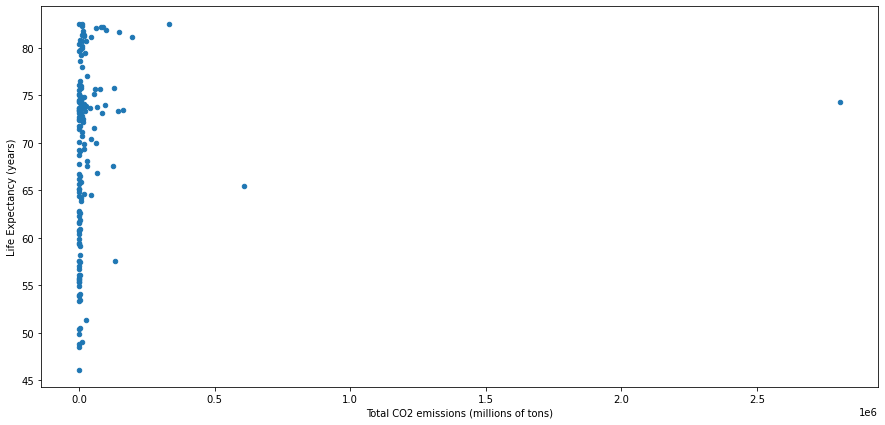

In [88]:
axLE = cleanSort.plot.scatter(x='totalCO2emission', y='Life_expectancy_', figsize=(15, 7))
axLE = axLE.set(xlabel='Total CO2 emissions (millions of tons)', ylabel='Life Expectancy (years)')

In [89]:
# Pearson Correlation
cleanSort.totalCO2emission.corr(cleanSort.Life_expectancy_)

0.08951029521261442

## Conclusion:

There is no correlation between life expectancy and CO2 emissions. This could be because life expectancy is not a good predictor of CO2 emissions, or because the data is not representative of the real world.

If our result is true, it could mean that CO2 emissions do not have any relationship with life expectancy. One reason that there could be no correlation is that more developed countries could have higher CO2 emissions due to industrialization. These more developed countries may have better healthcare and living conditions, causing the adverse effects of more emissions to be nullified. In future studies, the correlation between developed countries and CO2 emissions should be researched further. A country's classification as developing or developed could be used to predict CO2 emissions. 

This claim could be true due to the outliers we see on our plot. There are many countries with low CO2 emissions, but the outliers with high CO2 emissions show a life expectancy that is average or slightly above average.

## Question: Does a country's use of renewable energy decrease their emissions? (Fairuz)
Does a country's use of renewable energy decrease their emissions? By evaluating this question, we can reach a conclusion about the extent to which renewable energy reduces CO2 emisions and thus benefits the environment. By computing the Pearson correlation coefficient for these two variables, we will gain insight into the effectiveness of renewable energy sources. 

Hypothesis: A general assumption can be made that increasing the use of renewable energy will decrease the use of non-renewable energy sources such as fossil-fuels, which will lead to a decrease in CO2 emisions.


To answer this inquiry, the following datasets will be used:

Renewable energy consumption (% of total final energy consumption): https://data.worldbank.org/indicator/EG.FEC.RNEW.ZS
* This data was taken from the World Bank and therefore it is assumed to be accurate data.
* The data shows the percentage of a country's total energy consumption that originated from renewable energy sources
* The data spans from 1990 to 2018

CO2 emissions (metric tons per capita): https://data.worldbank.org/indicator/EN.ATM.CO2E.PC
* This data was taken from the World Bank and therefore it is assumed to be accurate data.
* The data shows the CO2 emissions of a country in metric tons per capita
* The data spans from 1960 to 2018

## Analysis
First, several libraries need to be imported for analyzing and evaluating the data. Furthermore, the data will need to be read. A simple display of the data will help see how the tables are organized.

Note: Some reformatting of the csv files was required for the pandas library to read in the data. 

In [90]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

renewableEnergy = pandas.read_csv("RenewableEnergyConsumption.csv")
CO2Emissions = pandas.read_csv("CO2Emissions.csv")

renewableEnergy.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,0.268747,0.234955,0.238778,0.195134,0.183241,0.173372,...,0.299800,5.464700,5.661800,6.855900,6.889700,6.927500,6.728000,6.994600,6.6993,8.024100
1,Africa Eastern and Southern,AFE,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,61.625965,62.876319,64.636541,65.291676,65.379764,64.982510,...,61.252554,62.564529,62.293842,61.109554,60.468838,60.803934,61.097264,NaN,NaN,NaN
2,Afghanistan,AFG,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,15.924532,17.036444,26.521629,30.585667,32.796251,35.075640,...,17.850401,14.899000,11.559100,14.404900,17.105000,20.770300,20.273800,24.740299,25.0828,21.422701
3,Africa Western and Central,AFW,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,86.082214,85.443014,83.983071,85.305307,86.763667,86.348199,...,82.615425,80.933623,79.525293,79.071007,77.544229,76.276143,76.967527,NaN,NaN,NaN
4,Angola,AGO,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,72.255252,71.888639,72.723283,71.277056,72.220269,73.945888,...,52.413898,50.764801,49.239201,49.443298,47.938499,48.211300,47.815601,49.008099,56.1805,56.785500


In [91]:
CO2Emissions.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.906060,0.922474,0.930816,0.940570,0.996033,1.047280,...,1.021954,1.048876,1.005338,1.021646,1.031833,1.041145,0.987393,0.971016,0.959978,0.933541
2,Afghanistan,AFG,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.046057,0.053589,0.073721,0.074161,0.086174,0.101285,...,0.211306,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151
3,Africa Western and Central,AFW,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.090880,0.095283,0.096612,0.112376,0.133258,0.184803,...,0.426770,0.472819,0.497023,0.490867,0.504655,0.507671,0.480743,0.472959,0.476438,0.515544
4,Angola,AGO,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.100835,0.082204,0.210533,0.202739,0.213562,0.205891,...,1.205902,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380


Clean the data by removing unneeded columns. Make sure to retain copies of the original data in case reference to the original data is needed at any point. Furthermore, to make computations and visualizations less complex, I've decided to remove any countries with missing data. This will ensure we can see data that can be correlated and we will still have a large pool of data to compute with.

In [92]:
cleanEnergy = renewableEnergy.copy()

cleanEnergy.drop(['Country Code', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)
cleanEnergy = cleanEnergy.dropna()
cleanEnergy = cleanEnergy.reset_index(drop=True)

cleanEnergy

,Country Name,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,0.268747,0.234955,0.238778,0.195134,0.183241,0.173372,0.167474,0.160096,0.157876,...,0.299800,5.464700,5.661800,6.855900,6.889700,6.927500,6.728000,6.994600,6.699300,8.024100
1,Afghanistan,15.924532,17.036444,26.521629,30.585667,32.796251,35.075640,37.945748,41.432601,44.094337,...,17.850401,14.899000,11.559100,14.404900,17.105000,20.770300,20.273800,24.740299,25.082800,21.422701
2,Angola,72.255252,71.888639,72.723283,71.277056,72.220269,73.945888,73.139600,73.734416,76.819794,...,52.413898,50.764801,49.239201,49.443298,47.938499,48.211300,47.815601,49.008099,56.180500,56.785500
3,Albania,25.518088,32.998174,46.813329,51.152042,51.459544,50.609710,51.636361,55.953349,49.983365,...,37.215199,37.113701,35.961102,40.046700,41.286999,38.697399,38.625599,39.587299,37.219799,38.266399
4,Andorra,14.273550,14.273550,14.308754,13.918955,14.561024,14.481048,14.100048,14.194002,14.458642,...,17.126301,18.670900,18.552200,18.762899,19.141300,19.420099,19.277700,19.255800,19.063200,18.506001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,46.204609,46.238269,45.701427,46.142015,46.151734,45.218114,44.749726,44.841109,44.978561,...,43.277199,41.275600,40.264301,40.259300,42.614899,41.244900,37.478199,36.817699,35.809299,36.618599
193,"Yemen, Rep.",2.148638,1.709434,1.580226,1.792120,1.743376,1.504256,1.480847,1.397901,1.291669,...,0.877400,0.978600,1.155500,1.351700,0.945900,0.955600,2.419500,2.986100,3.401300,4.269000
194,South Africa,16.627822,17.466119,18.363217,18.585950,18.562882,18.113080,17.437771,17.107191,17.272490,...,10.987500,11.787700,11.371800,10.607500,9.782000,9.908100,10.291700,10.705300,10.225400,10.343300
195,Zambia,82.982734,82.253158,82.706777,85.135107,86.856529,87.111331,89.640857,87.007385,87.755545,...,89.797096,89.869400,88.750000,86.505096,86.562302,86.002701,85.487000,85.591499,84.687798,85.104599


Do the same as above, but here remove the columns from 1960 to 1989 as well, since in this case that data is irrelevant.

In [93]:
cleanCO2 = CO2Emissions.copy()

cleanCO2.drop(cleanCO2.iloc[:, 1:34], inplace=True, axis=1)
cleanCO2 = cleanCO2.dropna()
cleanCO2 = cleanCO2.reset_index(drop=True)

cleanCO2

,Country Name,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Africa Eastern and Southern,1.017505,0.971324,0.931920,0.925465,0.918612,0.946475,0.951132,0.971563,0.969680,...,1.021954,1.048876,1.005338,1.021646,1.031833,1.041145,0.987393,0.971016,0.959978,0.933541
1,Afghanistan,0.238473,0.206030,0.098719,0.085986,0.076131,0.069020,0.062588,0.056827,0.053197,...,0.211306,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151
2,Africa Western and Central,0.440470,0.474868,0.516677,0.518952,0.492858,0.487495,0.507633,0.488416,0.461622,...,0.426770,0.472819,0.497023,0.490867,0.504655,0.507671,0.480743,0.472959,0.476438,0.515544
3,Angola,0.534250,0.533109,0.503264,0.527723,0.495418,0.773026,0.792321,0.788753,0.740254,...,1.205902,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380
4,Albania,1.840841,1.258116,0.689859,0.641406,0.667179,0.611710,0.621837,0.470098,0.575350,...,1.475652,1.572251,1.734823,1.579092,1.654524,1.806789,1.759987,1.714126,1.948872,1.939732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Samoa,0.675688,0.670732,0.725119,0.718060,0.711368,0.705675,0.759501,0.755528,0.810002,...,1.029515,1.021813,1.066843,1.057703,1.048702,1.092498,1.240246,1.542099,1.535642,1.631588
233,"Yemen, Rep.",0.567037,0.690937,0.704793,0.595566,0.593106,0.661825,0.651614,0.679157,0.713057,...,1.139166,1.036068,0.869051,0.804146,1.047834,1.034330,0.536269,0.400468,0.361418,0.326682
234,South Africa,6.729799,6.424622,6.175430,6.217680,6.212642,6.375894,6.486114,6.721030,6.787882,...,8.004039,8.300179,7.867124,8.076633,8.137333,8.213158,7.671202,7.564451,7.632729,7.496645
235,Zambia,0.340930,0.349232,0.337224,0.291111,0.241270,0.234153,0.188442,0.237559,0.219937,...,0.186907,0.194032,0.218210,0.277909,0.284058,0.311693,0.319282,0.341615,0.414748,0.446065


Now we need to merge the datasets to easily view the data as a whole. But in both datasets, there are identical columns, so horizontally merging may make some of the column names ambiguous. One thing that can be done is to rename the column names by adding suffixes and then merging.

In [94]:
mergedData = cleanEnergy.merge(cleanCO2, on='Country Name', suffixes=('_energy', '_CO2'))
mergedData

,Country Name,1990_energy,1991_energy,1992_energy,1993_energy,1994_energy,1995_energy,1996_energy,1997_energy,1998_energy,...,2009_CO2,2010_CO2,2011_CO2,2012_CO2,2013_CO2,2014_CO2,2015_CO2,2016_CO2,2017_CO2,2018_CO2
0,Afghanistan,15.924532,17.036444,26.521629,30.585667,32.796251,35.075640,37.945748,41.432601,44.094337,...,0.211306,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151
1,Angola,72.255252,71.888639,72.723283,71.277056,72.220269,73.945888,73.139600,73.734416,76.819794,...,1.205902,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380
2,Albania,25.518088,32.998174,46.813329,51.152042,51.459544,50.609710,51.636361,55.953349,49.983365,...,1.475652,1.572251,1.734823,1.579092,1.654524,1.806789,1.759987,1.714126,1.948872,1.939732
3,Andorra,14.273550,14.273550,14.308754,13.918955,14.561024,14.481048,14.100048,14.194002,14.458642,...,6.156688,6.157198,5.850886,5.944654,5.942801,5.807128,6.026182,6.080600,6.104134,5.973405
4,United Arab Emirates,0.000000,0.000000,0.188369,0.150356,0.120145,0.112604,0.080332,0.076356,0.072470,...,19.852557,19.043279,18.589933,19.223116,20.015421,19.951852,20.948092,21.307610,21.950614,20.797498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,46.204609,46.238269,45.701427,46.142015,46.151734,45.218114,44.749726,44.841109,44.978561,...,1.029515,1.021813,1.066843,1.057703,1.048702,1.092498,1.240246,1.542099,1.535642,1.631588
174,"Yemen, Rep.",2.148638,1.709434,1.580226,1.792120,1.743376,1.504256,1.480847,1.397901,1.291669,...,1.139166,1.036068,0.869051,0.804146,1.047834,1.034330,0.536269,0.400468,0.361418,0.326682
175,South Africa,16.627822,17.466119,18.363217,18.585950,18.562882,18.113080,17.437771,17.107191,17.272490,...,8.004039,8.300179,7.867124,8.076633,8.137333,8.213158,7.671202,7.564451,7.632729,7.496645
176,Zambia,82.982734,82.253158,82.706777,85.135107,86.856529,87.111331,89.640857,87.007385,87.755545,...,0.186907,0.194032,0.218210,0.277909,0.284058,0.311693,0.319282,0.341615,0.414748,0.446065


### Note
To see an interactive graphic visualization of this data, follow the links in the Question section above and you will be able to see the world data as well as the data for each country.

The next part of this analysis will deal with only the latest year: 2018. We will find the correlation between emissions and renewable energy usage for the most current data, instead of relying on potentially outdated data.

In [95]:
data2018 = pandas.DataFrame().assign(CN=mergedData['Country Name'], EC=mergedData['2018_energy'], 
                                     C2 = mergedData['2018_CO2'])

data2018 = data2018.rename(columns={'CN': 'Country Name', 'EC': 'Renewable Energy Consumption Percentage', 'C2' : 
                         'CO2 Emissions (Metric Tons Per Capita)'})

data2018

,Country Name,Renewable Energy Consumption Percentage,CO2 Emissions (Metric Tons Per Capita)
0,Afghanistan,21.422701,0.200151
1,Angola,56.785500,0.887380
2,Albania,38.266399,1.939732
3,Andorra,18.506001,5.973405
4,United Arab Emirates,0.259200,20.797498
...,...,...,...
173,Samoa,36.618599,1.631588
174,"Yemen, Rep.",4.269000,0.326682
175,South Africa,10.343300,7.496645
176,Zambia,85.104599,0.446065


Now we can visualize the data for both energy consumption and CO2 emissions in the year 2018.

<AxesSubplot:xlabel='Renewable Energy Consumption Percentage', ylabel='CO2 Emissions (Metric Tons Per Capita)'>

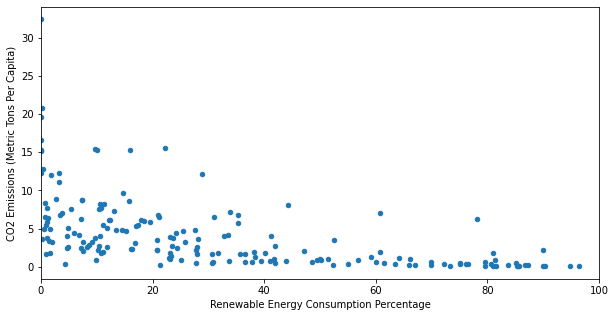

In [96]:
data2018.plot.scatter(x='Renewable Energy Consumption Percentage', y='CO2 Emissions (Metric Tons Per Capita)', figsize=(10,5), xlim=(0 ,100))

We can see a general trend in the fact that countries with lower renewable energy consumption percentages had higher CO2 emissions per capita. However, this trend seems to become less pronounced at renewable energy consumption percentages above 40%.

Finally, lets look at the correlation value between the 2 variables for the year 2018.

In [97]:
data2018['Renewable Energy Consumption Percentage'].corr(data2018['CO2 Emissions (Metric Tons Per Capita)'])

-0.5423796078116238

## Conclusion

As per the analysis above, we can see that there is some truth to the hypothesis made in the question section. The hypothesis stated that as renewable energy consumption decreased, CO2 emissions would increase. From the analysis we can see that the data has a correlation coefficent of about -0.5. While this doesn't strongly support the hypothesis, it does indicate that both of these variables are somewhat related in that lower renewable energy use does increase CO2 emissions. 

Furthermore, visualizing the data for 2018 helps to understand the trend in the data a little bit better. From the scatterplot above, one can see that the countries with the highest CO2 emissions per capita had the lowest renewable energy consumption. However, as renewable energy consumption increased, the trend discontinued at around 40% of renewable energy consumption. This may indicate that there is a threshold at which the renewable energy consumption gives diminishing returns in terms of reducing CO2 emissions.

Limitiations and errors may have occured with this data analysis, as there were several factors that could lead to different results. First and foremost, if raw CO2 emissions in metric tons were used instead of CO2 emissions per capita, we could have seen a different trend in the data. This could be a potential update to this analysis. A limitation to this analysis was the fact that only one year was used to evaluate, but there was a choice of 28 years. Although it might complicate and elongate the evaluation, one could review the trends for each of the 28 years and come up with an average trend.


## Question: Which Countries produce the most greenhouse gases? Which countries produce the least? (Jonathan)

Which coutries produce the most and least greenhouse gas emissions? By determining which countries have been producing the most and least greenhouse gases, we can better understand what greenhouse gas emissions have to do with human activity. By finding the countries that produce the most and least greenhouse gases, we can also generate new questions about the characteristics of those countries which may cause them to produce a greater amount of emissions. 

In order to answer this question, data from https://www.kaggle.com/saurabhshahane/green-house-gas-historical-emission-data will be utilized. This data contains greenhouse gas emissions data for 194 countries from 1990-2018. The dataset was extracted from the World Resources Institute.

The unit for this dataset is MtCO2e, which is Metric tons of carbon dioxide equivalent.

## Analysis:
We will use pandas, numpy, and matplotlib to sort and analyze the data.

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We will start by pulling our data from the csv file we have acquired from the website.

In [99]:
dirty = pd.read_csv("ghg-emissions.csv")

Preview of the data.

In [100]:
dirty.head()

,Country/Region,unit,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,China,MtCO2e,2873.71,3023.38,3154.54,3377.79,3528.81,3918.30,3954.75,3963.61,...,9046.19,9872.37,10364.83,10690.04,11144.76,11155.76,11149.68,11207.66,11408.26,11705.81
1,United States,MtCO2e,5543.47,5501.92,5583.80,5691.26,5782.20,5843.90,6010.62,6258.47,...,5793.66,6041.59,5796.78,5550.87,5690.79,5711.15,5586.69,5676.92,5613.64,5794.35
2,India,MtCO2e,1009.44,1064.49,1096.71,1128.44,1174.78,1240.44,1289.63,1348.09,...,2467.78,2576.93,2610.32,2758.53,2816.49,2988.34,3002.17,3073.24,3202.82,3346.63
3,Russia,MtCO2e,2885.12,2788.70,2551.94,2294.62,2011.47,1930.88,1889.18,1755.59,...,1575.54,1690.93,1864.86,1886.41,1844.48,1841.26,1791.21,1918.26,1939.26,1992.08
4,Indonesia,MtCO2e,1257.10,1274.43,1295.01,1311.27,1327.87,1360.88,1179.00,2142.82,...,1483.61,1125.25,1675.72,1695.27,1636.17,2016.28,2070.24,1453.23,1466.05,1703.86


In [101]:
dirty

,Country/Region,unit,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,China,MtCO2e,2873.71,3023.38,3154.54,3377.79,3528.81,3918.30,3954.75,3963.61,...,9046.19,9872.37,10364.83,10690.04,11144.76,11155.76,11149.68,11207.66,11408.26,11705.81
1,United States,MtCO2e,5543.47,5501.92,5583.80,5691.26,5782.20,5843.90,6010.62,6258.47,...,5793.66,6041.59,5796.78,5550.87,5690.79,5711.15,5586.69,5676.92,5613.64,5794.35
2,India,MtCO2e,1009.44,1064.49,1096.71,1128.44,1174.78,1240.44,1289.63,1348.09,...,2467.78,2576.93,2610.32,2758.53,2816.49,2988.34,3002.17,3073.24,3202.82,3346.63
3,Russia,MtCO2e,2885.12,2788.70,2551.94,2294.62,2011.47,1930.88,1889.18,1755.59,...,1575.54,1690.93,1864.86,1886.41,1844.48,1841.26,1791.21,1918.26,1939.26,1992.08
4,Indonesia,MtCO2e,1257.10,1274.43,1295.01,1311.27,1327.87,1360.88,1179.00,2142.82,...,1483.61,1125.25,1675.72,1695.27,1636.17,2016.28,2070.24,1453.23,1466.05,1703.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Nauru,MtCO2e,0.13,0.13,0.13,0.12,0.12,0.11,0.11,0.11,...,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.07,0.07,0.08
191,Tuvalu,MtCO2e,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03
192,Niue,MtCO2e,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01
193,Data source,CAIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, there are couple rows that we do not need for our analysis. Let's clean up the dataset.

In [102]:
clean = pd.DataFrame()
clean = dirty
clean = clean[clean["unit"] == "MtCO2e"]
clean

,Country/Region,unit,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,China,MtCO2e,2873.71,3023.38,3154.54,3377.79,3528.81,3918.30,3954.75,3963.61,...,9046.19,9872.37,10364.83,10690.04,11144.76,11155.76,11149.68,11207.66,11408.26,11705.81
1,United States,MtCO2e,5543.47,5501.92,5583.80,5691.26,5782.20,5843.90,6010.62,6258.47,...,5793.66,6041.59,5796.78,5550.87,5690.79,5711.15,5586.69,5676.92,5613.64,5794.35
2,India,MtCO2e,1009.44,1064.49,1096.71,1128.44,1174.78,1240.44,1289.63,1348.09,...,2467.78,2576.93,2610.32,2758.53,2816.49,2988.34,3002.17,3073.24,3202.82,3346.63
3,Russia,MtCO2e,2885.12,2788.70,2551.94,2294.62,2011.47,1930.88,1889.18,1755.59,...,1575.54,1690.93,1864.86,1886.41,1844.48,1841.26,1791.21,1918.26,1939.26,1992.08
4,Indonesia,MtCO2e,1257.10,1274.43,1295.01,1311.27,1327.87,1360.88,1179.00,2142.82,...,1483.61,1125.25,1675.72,1695.27,1636.17,2016.28,2070.24,1453.23,1466.05,1703.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Kiribati,MtCO2e,0.04,0.04,0.04,0.05,0.04,0.05,0.05,0.05,...,0.08,0.08,0.08,0.08,0.09,0.09,0.09,0.10,0.10,0.11
189,Cook Islands,MtCO2e,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.05,...,0.07,0.07,0.08,0.08,0.08,0.08,0.08,0.09,0.09,0.10
190,Nauru,MtCO2e,0.13,0.13,0.13,0.12,0.12,0.11,0.11,0.11,...,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.07,0.07,0.08
191,Tuvalu,MtCO2e,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03


Let's find the total MtCO2e values for each country through the time period 1990-2018.

In [103]:
clean["total"] = clean.sum(axis=1)

/var/folders/36/cxl_j36x7xbb6wt_1xlbgg980000gp/T/ipykernel_4551/4035234782.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  clean["total"] = clean.sum(axis=1)
/var/folders/36/cxl_j36x7xbb6wt_1xlbgg980000gp/T/ipykernel_4551/4035234782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean["total"] = clean.sum(axis=1)


Here, I have added a new column named "total" that represent the total green house gas emission from 1990 to 2018.

In [104]:
clean

,Country/Region,unit,1990,1991,1992,1993,1994,1995,1996,1997,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,total
0,China,MtCO2e,2873.71,3023.38,3154.54,3377.79,3528.81,3918.30,3954.75,3963.61,...,9872.37,10364.83,10690.04,11144.76,11155.76,11149.68,11207.66,11408.26,11705.81,196856.05
1,United States,MtCO2e,5543.47,5501.92,5583.80,5691.26,5782.20,5843.90,6010.62,6258.47,...,6041.59,5796.78,5550.87,5690.79,5711.15,5586.69,5676.92,5613.64,5794.35,167632.00
2,India,MtCO2e,1009.44,1064.49,1096.71,1128.44,1174.78,1240.44,1289.63,1348.09,...,2576.93,2610.32,2758.53,2816.49,2988.34,3002.17,3073.24,3202.82,3346.63,57354.89
3,Russia,MtCO2e,2885.12,2788.70,2551.94,2294.62,2011.47,1930.88,1889.18,1755.59,...,1690.93,1864.86,1886.41,1844.48,1841.26,1791.21,1918.26,1939.26,1992.08,51709.17
4,Indonesia,MtCO2e,1257.10,1274.43,1295.01,1311.27,1327.87,1360.88,1179.00,2142.82,...,1125.25,1675.72,1695.27,1636.17,2016.28,2070.24,1453.23,1466.05,1703.86,40335.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Kiribati,MtCO2e,0.04,0.04,0.04,0.05,0.04,0.05,0.05,0.05,...,0.08,0.08,0.08,0.09,0.09,0.09,0.10,0.10,0.11,1.99
189,Cook Islands,MtCO2e,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.05,...,0.07,0.08,0.08,0.08,0.08,0.08,0.09,0.09,0.10,1.72
190,Nauru,MtCO2e,0.13,0.13,0.13,0.12,0.12,0.11,0.11,0.11,...,0.05,0.05,0.05,0.05,0.06,0.06,0.07,0.07,0.08,2.27
191,Tuvalu,MtCO2e,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.58


Here, I have created a final data frame that takes in the clean data from before and sorts it by the "Total Emission from 1990 to 2018" value.

In [105]:
final = pd.DataFrame()
final["Country"] = clean["Country/Region"]
final["unit"] = clean["unit"]
final["Total Emission from 1990 to 2018"] = clean["total"]
final = final.sort_values(by = "Total Emission from 1990 to 2018")
final

,Country,unit,Total Emission from 1990 to 2018
170,Bhutan,MtCO2e,-97.95
183,Fiji,MtCO2e,-6.64
192,Niue,MtCO2e,0.25
191,Tuvalu,MtCO2e,0.58
189,Cook Islands,MtCO2e,1.72
...,...,...,...
5,Brazil,MtCO2e,48315.37
3,Russia,MtCO2e,51709.17
2,India,MtCO2e,57354.89
1,United States,MtCO2e,167632.00


We can see there are some data points that are not helpful for us. We will remove these countries. 

In [106]:
final = final[final["Total Emission from 1990 to 2018"] >= 0]
final

,Country,unit,Total Emission from 1990 to 2018
192,Niue,MtCO2e,0.25
191,Tuvalu,MtCO2e,0.58
189,Cook Islands,MtCO2e,1.72
188,Kiribati,MtCO2e,1.99
190,Nauru,MtCO2e,2.27
...,...,...,...
5,Brazil,MtCO2e,48315.37
3,Russia,MtCO2e,51709.17
2,India,MtCO2e,57354.89
1,United States,MtCO2e,167632.00


This is the number of missing rows, as we eliminated some for comprehensible data.

In [107]:
dirty.shape[0] - final.shape[0]

4

These two countries are the countries with the least and most amount of greenhouse gas emissions from 1990 to 2018.

In [108]:
least = final.iloc[0]
most = final.iloc[-1]

In [109]:
least

Country                               Niue
unit                                MtCO2e
Total Emission from 1990 to 2018      0.25
Name: 192, dtype: object

In [110]:
most

Country                                 China
unit                                   MtCO2e
Total Emission from 1990 to 2018    196856.05
Name: 0, dtype: object

## Conclusion:
We found that the country that produces the most greenhouse gas emissions is China, while the country that produces the least is Niue. This makes sense, as Niue is a small, isolated island located in the South Pacific Ocean, while China is located in the middle of Asia and is one of the biggest, if not the biggest manufacturing country in the world.  

Other major contributors of greenhouse gases include The United States, India, Russia, and Brazil. Besides Niue, countries which have the smallest carbon footprint include Tuvalu, The Cook Islands, Kiribati, and Nauru. In general, it appears that industrial powerhouses are responsible for the majority of emissions. On the other hand, island nations which are isolated from the rest of the world and which may have relatively self-contained economies have the least CO2 emissions. 

We can use this information to determine if greenhouse gas emissions have any correlations with trade. Countries like China, The United States, and India all have large economies with a lot of exports. On the other hand, smaller island nations, like Niue and Tuvalu, probably have a relatively small export market. Therefore, it is quite possible that trade has a correlation with CO2 emissions. A logical next step would be to analyze the effects of both domestic and international trade on CO2 emissions. 

One limitation of this analysis is that emission data from 1990-2018 was used. Therefore, the data may not be quite as up to date as current data, which may affect our results slightly. However, we still anticipate that our data is mostly accurate, and it certainly helps us determine what characteristics of a country may be associated with higher volumes of CO2 emissions. 